# Building a Pipeline for Aspect-Entity Extraction with Natural Language Programming 

Natural Language Processing (NLP) involves the task of inferring useful information from text. Most elementary demonstrations of NLP involve sentiment analysis, i.e. categorizing an opinion as positive or negative. In this demonstration I tackle a more sophisticated task, namely <a href="https://link.springer.com/chapter/10.1007/978-3-642-40837-3_1" target="_blank">**aspect-entity**</a> extraction. 

I'll show how we can build a machine learning pipeline for analysing customer reviews of restaurants that identifies:
1. All ***entites*** for which opinions are being expressed, e.g. the restaurant, the food, or the service, along with their specific "target" words or "opinion-term expressions" (OTEs); i.e. the waiter, the roast beef, the wine, the decor.  
2. The particular ***aspect*** of those entities being discussed; i.e. quality, price. 
3. And the particular ***sentiment*** being expressed towards the aspect-entity pair; i.e. positive, negative, or neutral.

In the process, we'll see how to implement several important NLP techniques, including:
> * Text cleaning, contraction expansion, and lemmatization. 
* Converting text sequence elements into pretrained embedding vectors. 
* Creating Parts-of-Speech (POS) tags. 
* Sequence-to-sequence IOB2 tagging for entity identification. 
* Creating an end-to-end inference pipeline. 

Our final network will be able to take the following example input phrase...

> *"Service was terribly slow and the restaurant was noisy, but the waiter was friendly and the calamari was very delicious."*

... and produce the following output:

|  | 1    | 2    |   3  | 4 |
|------:|:------:|:------:|:------:| :------:|
|   **OTE Target Words:**  |  ['service'] |     ['restaurant'] |  ['waiter']    | ['calamari']|
|   **Entity-Aspect:**   | SERVICE:GENERAL |   AMBIENCE:GENERAL   | SERVICE:GENERAL   |  FOOD:QUALITY |
|   **Polarity:** | negative| negative     |   positive   | positive|
| |<img width=150/>|<img width=150/>|<img width=150/>|<img width=150/> |


***
## Contents

[**Background and Dataset**](#section_0)

1) [**Viewing and Parsing the Dataset**](#section_1)

2) [**Data Exploration**](#section_2)
    
3) [**Data Pre-Processing**](#section_3)
* 3.1 -  [Cleaning the Text](#section_3_1)
* 3.2 -  [Word Indexing](#section_3_2)
* 3.3 -  [Word Embedding](#section_3_3)
* 3.4 -  [Sequence Padding](#section_3_4)
* 3.5 -  [Generating IOB2 Tags](#section_3_5)
* 3.6 -  [Generating Part-of-Speech (POS) Tags](#section_3_6)
* 3.7 -  [Handling Sentences with Multiple OTEs](#section_3_7)
* 3.8 -  [Category, Aspect, and Polarity Label Extraction](#section_3_8)
* 3.9 -  [Saving and Reloading Preprocessed Data Files](#section_3_9)

4) [**OTE Extraction via Sequence-to-Sequence Tagging**](#section_4)
* 4.1 -  [Model Definition ](#section_4_1)
* 4.2 -  [Model Training](#section_4_2)
* 4.3 -  [Examining our IOB2 Tagger Predictions](#section_4_3)
* 4.4 -  [Inference on our own Review Sentences](#section_4_4)

5) [**Aspect-Entity and Sentiment Extraction**](#section_5)
* 5.1 -  [Data Prep](#section_5_1)
* 5.2 -  [Model Definition](#section_5_2)
* 5.3 -  [Model Training and Evaluation](#section_5_3)

6) [**Complete Inference Pipeline using Combined Model**](#section_6)
    
7) [**Final Remarks**](#section_7)
    

***
### Importing Python Libraries

In [1]:
# general
import gc  # garbage collection for memory management
import re  # regular expressions toolkit
import os
import json
import shutil
import math
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

# data preprocessing
import xml.etree.ElementTree as ET  # for xml file parsing
from collections import Counter  # for counting word occurences
from pycontractions import Contractions  # for contraction expansion
from nltk.stem import WordNetLemmatizer  # for word Lemmatization
from nltk.tag.stanford import StanfordPOSTagger  # Part-of-Speech tags
from tensorflow.python.keras.preprocessing import sequence  # for padding

# keras model creation
import keras as K
import keras.backend as KB
print('Using Keras Version', K.__version__)
from keras.layers import Conv1D, Dropout, Embedding
from keras.layers import Dense, TimeDistributed

# data visualization
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from prettytable import PrettyTable  # formatted text-based tables
from tensorboard import summary
from tensorboard.plugins.custom_scalar import layout_pb2
from keras.utils.vis_utils import plot_model  # for viewing model graphs

# TensorFlow Logging
tf.logging.set_verbosity(tf.logging.INFO)


Using Keras Version 2.2.2


Using TensorFlow backend.


***
<a id='section_0'></a>
##  Background and Dataset
Whereas sentiment analysis in the past has focused mostly on classifying the overall polarity of a statement or document, Aspect-Based Sentiment Analysis (ABSA) is a newer and more challenging framework that seeks to understand specific sentiments towards different aspects of an entity. For example, the review sentence *"Service was devine, oysters were as great as they come, and the price can't be beat!!!"* contains three different (OTE, entity:aspect, polarity) tuples:
1. ("service", SERVICE:GENERAL, positive)
2. ("oysters", FOOD:QUALITY, positive)
3. ("price", RESTAURANT:PRICES, positive)

To develop our ABSA pipeline, we'll use a dataset that was part of a competitive challege at the International Workshop on Semantic Evaluation (SemEval-2016), which can be found <a href="http://alt.qcri.org/semeval2016/task5/" target="_blank">here</a>. The dataset consists of 350 review texts (2000 sentences) that have been annotated with roughly 2500 (entity, aspect, polarity) tuples. The relatively small size of the training set is part of the challenge. 

Our focus in this demonstration will be on developing the NLP pipeline. We won't worry so much about the specific deep learning models used nor their performance. Once we've built the pipeline, it becomes fairly straightforward to train on much larger text corpuses, import pretrained models for transfer learning, and experiment with the neural network architecture. 


**Strategy**
    
Our pipeline will consist of two trained models in serial:

> **Step 1**: Identify all opinion target expressions (OTEs, the specific words describing the entities about which opinions are expressed) within a given sentence. For this we'll perform sequence-to-sequence IOB2 tagging with using a convolutional neural network (CNN) with a time-distributed dense layer at the output. The inputs will be padded tokenized word sequences and a pretrained embedding matrix. The output will be IOB2 tags that identify the sequence locations of the OTEs (i.e. the entity terms). 

> **Step 2**: For each OTE identified within each review sentence, we will futher identify (a) the entity:aspect pair (e.g. FOOD:QUALITY) and (b) the sentiment polarity (positive, negative, or neutral). For this, we will use a recursive neural network (RNN) based on long short-term memory (LTSM) stacked on top of a CNN. The inputs will be tokenized word sequences, a pretrained embedding matrix, part-of-speech (POS) tags, and IOB2 tags identifying the OTE positions. The output will be the aspect and polarity associated with that particular OTE/entity. 


***
<a id='section_1'></a>
## 1) Viewing and Parsing the Dataset

Let's take a moment to get familiar with the XML file structure. One quick way to view an XML tree is to drag and drop the xml file onto a new tab in your internet browser (e.g. Chrome):

<img src='http://rpmarchildon.com/wp-content/uploads/2018/10/xml-file-snippet.jpg' style="width: 600px;">

Exploring the data, we find that some sentences have multiple associated entity-aspect opinions (as expected), while others have no associated opinion at all. 

We'll organize our data into a pandas dataframe having the following columns:
* **opinion_id** (identifier, given in format <Review_id>:<Sentence_id>:<E#A_id>, e.g. 1004293:0:0)
* **text** (string, containing a text sentence from the review)
* **target** (the words identifying the entity)
* **category** (identifies the entity-aspect category, e.g. FOOD#QUALITY)
* **polarity** (positive, negative, neutral)
* **ote_start** (string character offset identifying where the OTE begins within the sentence)
* **ote_stop** (string character offset identifying where the OTE ends within the sentence)

For sentences with no associated opinion, we'll still create a row entry, and simply insert NaN in the relevant columns. 

Let's create a function that extracts and repackages the data from our xml files (xml = "extensible markup language"). For this, we'll use Python's ElementTree module:

In [2]:
def data_xml_to_df(xml_file):
    """
    Converts our raw xml data file into a pandas dataframe; xml tree structure is
    specific to the data files found at http://alt.qcri.org/semeval2016/task5/. 
    
    :param xml_file: xml filetype, the raw data we wish to process
    
    :return df: pandas dataframe, contains the extracted data sorted into the
                following columns: opinion_id, text_content, target, category, 
                polarity, ote_start, ote_stop
    
    """
    
    # parse the xml file
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # initialize variables to populate
    opinion_id = []
    text_content = []
    target = []
    category = []
    polarity = []
    ote_start = []
    ote_stop = []
    
    # jump directly to the 'sentence' branches and iterate
    for sentence in root.iter('sentence'):

        sentence_id = sentence.get('id')
        sentence_text = sentence.find('text').text
        opinions = sentence.find('Opinions')    
        
        # the number of opinions associated with a sentence varies
        if opinions is None:  # no associated opinions...
            opinion_id.append(sentence_id + ':0')
            text_content.append(sentence_text)
            target.append(np.nan)
            category.append(np.nan)
            polarity.append(np.nan)
            ote_start.append(np.nan)
            ote_stop.append(np.nan)      
        else:  # one or more opinions...
            for (i, opinion) in enumerate(sentence.find('Opinions')):
                opinion_id.append(sentence_id + ':%s' % i)
                text_content.append(sentence_text)
                target.append(opinion.get('target'))
                category.append(opinion.get('category'))
                polarity.append(opinion.get('polarity'))
                ote_start.append(opinion.get('from'))
                ote_stop.append(opinion.get('to'))

    # Now convert to dataframe:
    # (column names are specified upfront to define column order)
    df = pd.DataFrame(columns=['opinion_id', 
                               'text', 
                               'target',
                               'category', 
                               'polarity',
                               'ote_start', 
                               'ote_stop'])
    
    df['opinion_id'] = opinion_id
    df['text'] = text_content
    df['target'] = target
    df['category'] = category
    df['polarity'] = polarity
    df['ote_start'] = ote_start
    df['ote_stop'] = ote_stop
    
    return df


Now let's use our function to extract the data and preview one of the dataframes:

In [3]:
# specify file paths
data_xml_train = './SemEval2016-Task5/ABSA16_Restaurants_Train_SB1_v2.xml'
data_xml_test = './SemEval2016-Task5/restaurants_trial_english_sl.xml'

# convert to pandas dataframes
df_train = data_xml_to_df(data_xml_train)
df_test =  data_xml_to_df(data_xml_test)

# preview
df_train.head(10)

,opinion_id,text,target,category,polarity,ote_start,ote_stop
0,1004293:0:0,Judging from previous posts this used to be a ...,place,RESTAURANT#GENERAL,negative,51,56
1,1004293:1:0,"We, there were four of us, arrived at noon - t...",staff,SERVICE#GENERAL,negative,75,80
2,1004293:2:0,"They never brought us complimentary noodles, i...",NULL,SERVICE#GENERAL,negative,0,0
3,1004293:3:0,The food was lousy - too sweet or too salty an...,food,FOOD#QUALITY,negative,4,8
4,1004293:3:1,The food was lousy - too sweet or too salty an...,portions,FOOD#STYLE_OPTIONS,negative,52,60
5,1004293:4:0,"After all that, they complained to me about th...",NULL,SERVICE#GENERAL,negative,0,0
6,1004293:5:0,Avoid this place!,place,RESTAURANT#GENERAL,negative,11,16
7,1014458:0:0,"I have eaten at Saul, many times, the food is ...",food,FOOD#QUALITY,positive,38,42
8,1014458:1:0,Saul is the best restaurant on Smith Street an...,Saul,RESTAURANT#GENERAL,positive,0,4
9,1014458:2:0,The duck confit is always amazing and the foie...,foie gras terrine with figs,FOOD#QUALITY,positive,42,69


Next, we'll create a new feature, **ote**, which is merely **text_content** sampled between **ote_start** and **ote_stop**:

In [4]:
# generate new OTE feature
df_train['ote'] = df_train.apply(
    lambda row: np.nan if math.isnan(float(row['ote_start'])) 
        else (0 if row['ote_start']==row['ote_stop'] 
        else row['text'][int(row['ote_start']):int(row['ote_stop'])]), axis=1)

# preview result
column_list = ['text', 'category', 'target', 'ote_start', 'ote_stop', 'ote']
df_train[column_list].head(5)

,text,category,target,ote_start,ote_stop,ote
0,Judging from previous posts this used to be a ...,RESTAURANT#GENERAL,place,51,56,place
1,"We, there were four of us, arrived at noon - t...",SERVICE#GENERAL,staff,75,80,staff
2,"They never brought us complimentary noodles, i...",SERVICE#GENERAL,NULL,0,0,0
3,The food was lousy - too sweet or too salty an...,FOOD#QUALITY,food,4,8,food
4,The food was lousy - too sweet or too salty an...,FOOD#STYLE_OPTIONS,portions,52,60,portions


However, we discover that this new feature is identicla to **target**, so we won't end up using this variable. Good to know.

Some sentences have no entity#aspect pair, and thus show *NaN* in the category column, for example:

In [5]:
print('Text:', df_train.iloc[34].text)
print('E#A:', df_train.iloc[34].category)

Text: I had my eyes on this place, promising myself I will one day 'give it a try.' 
E#A: nan


Let's replace all such NaN values with the string 'NULL':

In [6]:
df_train = df_train.replace(np.nan, 'NULL', regex=True)
df_test = df_test.replace(np.nan, 'NULL', regex=True)

# check:
df_train.iloc[34]

opinion_id                                          1041457:0:0
text          I had my eyes on this place, promising myself ...
target                                                     NULL
category                                                   NULL
polarity                                                   NULL
ote_start                                                  NULL
ote_stop                                                   NULL
ote                                                        NULL
Name: 34, dtype: object

For convenience, let's also separate **category** into its **entity** and **aspect** components:

In [7]:
def df_split_category(dataframe):
    """
    Splits "category" into "entity" and "aspects" columns.
    Specific to our dataset. 
    
    """
    # Note: 'nan' for "category" gives type float, not str,
    # and we have used this for 'nan' detection.
    
    for i, feature in enumerate(['entity', 'aspect']):
        dataframe[feature] = dataframe.apply(
            lambda row: 'NULL' if row['category']=='NULL'
                else row['category'].split('#')[i], axis=1)
        
    return dataframe


# separate category into entity and aspect
df_train = df_split_category(df_train)
df_test = df_split_category(df_test)

# preview
feature_list = ['category', 'entity', 'aspect']
df_train[feature_list].head(10)


,category,entity,aspect
0,RESTAURANT#GENERAL,RESTAURANT,GENERAL
1,SERVICE#GENERAL,SERVICE,GENERAL
2,SERVICE#GENERAL,SERVICE,GENERAL
3,FOOD#QUALITY,FOOD,QUALITY
4,FOOD#STYLE_OPTIONS,FOOD,STYLE_OPTIONS
5,SERVICE#GENERAL,SERVICE,GENERAL
6,RESTAURANT#GENERAL,RESTAURANT,GENERAL
7,FOOD#QUALITY,FOOD,QUALITY
8,RESTAURANT#GENERAL,RESTAURANT,GENERAL
9,FOOD#QUALITY,FOOD,QUALITY


***
<a id='section_2'></a>
## 2) Data Exploration

Let's get a sense of the spectrum of entity-aspect pairs and targets we can have. Note that for ABSA problems, these are pre-defined up front. 

In [8]:
# combine test and train datasets
df_combined = pd.concat([df_train, df_test])

# extract instances
entity_list = []
aspect_list = []
category_list = []
target_list = []
for index, row in df_combined.iterrows():
    entity_list.append(row['entity'])
    aspect_list.append(row['aspect'])
    category_list.append(row['category'])
    target_list.append(row['target'])
    
# collect by unique entries
entity_counts = Counter(entity_list)
aspect_counts = Counter(aspect_list)
category_counts = Counter(category_list)
target_counts = Counter(target_list)

We find six possible entities (plus 'NULL'):

In [9]:
entity_counts

Counter({'AMBIENCE': 263,
         'DRINKS': 101,
         'FOOD': 1108,
         'LOCATION': 29,
         'NULL': 299,
         'RESTAURANT': 611,
         'SERVICE': 461})

And five possible aspects (plus 'NULL'):

In [10]:
aspect_counts

Counter({'GENERAL': 1184,
         'MISCELLANEOUS': 99,
         'NULL': 299,
         'PRICES': 193,
         'QUALITY': 927,
         'STYLE_OPTIONS': 170})

We can also see how these aspects are distributed among entities:


 aspect      GENERAL  MISCELLANEOUS  NULL  PRICES  QUALITY  STYLE_OPTIONS
entity                                                                  
AMBIENCE        263              0     0       0        0              0
DRINKS            0              0     0      20       48             33
FOOD              0              0     0      92      879            137
LOCATION         29              0     0       0        0              0
NULL              0              0   299       0        0              0
RESTAURANT      431             99     0      81        0              0
SERVICE         461              0     0       0        0              0


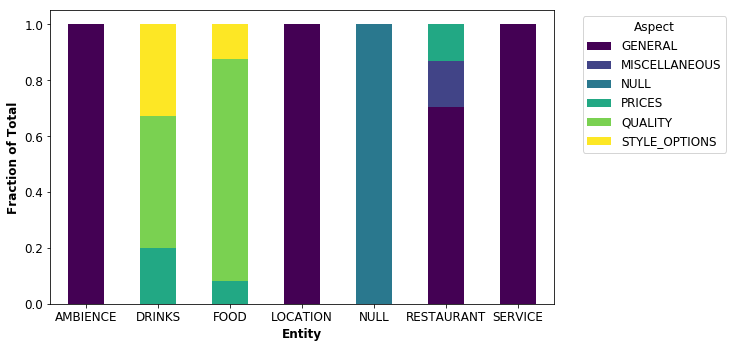

In [11]:
# generate cross-tabulation
table = pd.crosstab(df_combined['entity'], df_combined['aspect'])
print('\n', table)

# plot the aspect fractions for each entity
plt.rcParams['font.size'] = 12
table_fractions = table.div(table.sum(1).astype(float), axis=0)
g = table_fractions.plot(kind="bar", stacked=True, 
                         colormap='viridis', figsize=(8,5))
plt.xticks(rotation=0)
plt.xlabel('Entity', weight='bold')
plt.ylabel('Fraction of Total', weight='bold')
plt.tight_layout()
leg = plt.legend(title='Aspect', loc=9, bbox_to_anchor=(1.20, 1.0))


We see that ambience, location, and service have only one possible aspect; restaurant has two; food and drinks have three. The number of unique combinations is small enough that we might consider working with just **category**, rather than **entity** and **aspect** separately; on the other hand, the number of data samples available for each unique category (e.g. DRINKS#PRICES) is smaller than if we consider entity and aspect separately.

In [12]:
category_counts

Counter({'AMBIENCE#GENERAL': 263,
         'DRINKS#PRICES': 20,
         'DRINKS#QUALITY': 48,
         'DRINKS#STYLE_OPTIONS': 33,
         'FOOD#PRICES': 92,
         'FOOD#QUALITY': 879,
         'FOOD#STYLE_OPTIONS': 137,
         'LOCATION#GENERAL': 29,
         'NULL': 299,
         'RESTAURANT#GENERAL': 431,
         'RESTAURANT#MISCELLANEOUS': 99,
         'RESTAURANT#PRICES': 81,
         'SERVICE#GENERAL': 461})

For **target**, we find that most entries are unique and highly specific. Ideally, we want our model to identify OTE terms based on generic word patterns (or sentence structures), rather than by merely memorizing specific words.

In [13]:
target_counts

Counter({'"salt encrusted shrimp" appetizer': 1,
         '$10 10-piece dim sum combo': 1,
         '1st Ave spot': 1,
         'Al Di La': 1,
         'Ambiance': 1,
         'Ambience': 2,
         'Amma': 1,
         'Appetizers': 1,
         'Areo': 1,
         'Atmosphere': 2,
         'BBE $29 fixe prix menu': 2,
         'BBQ Salmon': 1,
         'BBQ ribs': 2,
         'BFC': 1,
         'Bagels': 1,
         "Baluchi's": 1,
         'Bark': 3,
         'Basil slice': 1,
         'Beef noodle soup': 1,
         'Big Wong': 2,
         'Bison': 1,
         "Bloom's": 2,
         'Bombay beer': 2,
         'Bukhara': 1,
         'Bukhara Grill': 1,
         'Caesar Salad': 1,
         'Cafe Noir': 2,
         'Cafe Spice': 1,
         'Casa La Femme': 5,
         'Casa la Femme': 1,
         'Casimir': 1,
         'Change Mojito': 1,
         'Cheese plate': 3,
         "Chef's tasting menu": 1,
         'Chennai Garden': 1,
         'Chicken teriyaki': 1,
         'Chilli Chicke

***
<a id='section_3'></a>
## 3) Data Pre-Processing
<a id='section_3_1'></a>
### 3.1 - Cleaning the Text

Before we start, let's preview some unprocessed sample sentences:

In [14]:
for i in [2, 3, 7, 23, 42]:
    print(df_train['text'][i], '\n')

They never brought us complimentary noodles, ignored repeated requests for sugar, and threw our dishes on the table. 

The food was lousy - too sweet or too salty and the portions tiny. 

I have eaten at Saul, many times, the food is always consistently, outrageously good. 

Went on a 3 day oyster binge, with Fish bringing up the closing, and I am so glad this was the place it O trip ended, because it was so great! 

Anyways, if you're in the neighborhood to eat good food, I wouldn't waste my time trying to find something, rather go across the street to Tamari. 



To aid model performance, we want to obtain the simplest representation of the text without losing useful information. The cleaning and pre-processing steps will include:
> 1. Expanding all English contractions. 
2. Removing unusual characters and emoticons. 
3. Converting all words to lowercase.
4. Removing numbers (e.g. '3').
5. Replacing slang/abbreviated word substitutions (i.e. 'u' --> 'you')
6. Lemmatizing words into their base form (e.g. computing, computed --> compute). 

In this case I am choosing not to remove stopwords, which are common parts of speech (is, and, or). The reason is that these provide useful information about sentence structure which will be valuable when identifying entity#aspect targets. 


**Contraction Expansion:**

We begin with contractions. Manually creating a dictionary to expand contractions can lead to ambiguities (e.g. I'd -> I had, or I would?), therefore we'll use the [pycontractions library](https://pypi.org/project/pycontractions/) for a more accurate *context-based* contraction expansion with the aid of Google's Word2Vec model.

In [15]:
# load up the Word2Vec model for context-based contraction expansion
cont = Contractions('/home/rpm/ML-models/GoogleNews-vectors-negative300.bin')
cont.load_models()

# test it out:
print('Before:', df_train['text'][42], '\n')
print('After:', list(cont.expand_texts([df_train['text'][42]], precise=True)))

# apply to all reviews
df_train['text'] = list(cont.expand_texts(df_train['text'], precise=True))
df_test['text'] = list(cont.expand_texts(df_test['text'], precise=True))

# release references and 'garbage collect' to free memory
del cont
gc.collect()

Before: Anyways, if you're in the neighborhood to eat good food, I wouldn't waste my time trying to find something, rather go across the street to Tamari. 

After: ['Anyways, if you are in the neighborhood to eat good food, I would not waste my time trying to find something, rather go across the street to Tamari.']


0

**Cleaning and Lemmatization:**

Next we'll apply the remaining pre-processing steps and tokenize our review sentences into words by whitespace. Note that we also need to save a copy of our text strings *prior* to lemmatization in order to generate **Part-of-Speech (POS) tags** later. 

In [16]:
def apply_substitutions(text_tokenized):
    # we'll only apply a single slang substitution here,
    # but many more are possible...
    text_tokenized = ['you' if word is 'u' else word for word in text_tokenized]
    return text_tokenized


def preprocessor(text):
    # remove unusual characters
    text = re.sub('<[^>]*>', '', text)
    
    # remove emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
        
    # convert all words to lowercase
    text = re.sub('[\W]+', ' ', text.lower()) + " ".join(emoticons).replace('-', '')
    
    # strip numbers
    text = re.sub(r'\d+', '', text)
    
    # tokenize by whitespace
    text_tokenized = text.split()
    
    # apply word substitutions (for slang correction)
    text_tokenized = apply_substitutions(text_tokenized)
    
    return text_tokenized


# for lemmatization after pre-processing
lemmatizer = WordNetLemmatizer()
def lemmatize(text_tokenized):
    return [lemmatizer.lemmatize(word, pos='v') for word in text_tokenized]


# generate dataframe entries containing the cleaned text
df_train['text_cln'] = df_train['text'].apply(preprocessor)
df_test['text_cln'] = df_test['text'].apply(preprocessor)

# generate dataframe entries containing cleaned AND lemmatized text
df_train['text_cln_lm'] = df_train['text_cln'].apply(lemmatize)
df_test['text_cln_lm'] = df_test['text_cln'].apply(lemmatize)


Let's view an example of a sentence before and after lemmatization:

In [17]:
print('Before Lemmatization:\n', df_train['text_cln'][2])
print('\nAfter Lemmatization:\n', df_train['text_cln_lm'][2])

Before Lemmatization:
 ['they', 'never', 'brought', 'us', 'complimentary', 'noodles', 'ignored', 'repeated', 'requests', 'for', 'sugar', 'and', 'threw', 'our', 'dishes', 'on', 'the', 'table']

After Lemmatization:
 ['they', 'never', 'bring', 'us', 'complimentary', 'noodles', 'ignore', 'repeat', 'request', 'for', 'sugar', 'and', 'throw', 'our', 'dish', 'on', 'the', 'table']


**Removing Empty Sentences:**

Note that there seem to be some 'empty' sentences, e.g. for which the original input was only a number or some other stripped character:

In [18]:
df_train.iloc[842].head()

opinion_id           1573534:8:0
text                          10
target                      NULL
category      RESTAURANT#GENERAL
polarity                positive
Name: 842, dtype: object

We'll remove these from our dataset:

In [19]:
def remove_empty_sentences(data):
    return data.loc[data['text_cln_lm'].apply(len) != 0]

df_train = remove_empty_sentences(df_train)
df_test= remove_empty_sentences(df_test)

**Viewing the Pre-Processed Text:**

Finally, let's examine the sentences we previewed in the beginning to see their final, post-processed form:

In [20]:
for i in [2, 3, 7, 23, 42]:
    print(df_train['text_cln_lm'][i], '\n')

['they', 'never', 'bring', 'us', 'complimentary', 'noodles', 'ignore', 'repeat', 'request', 'for', 'sugar', 'and', 'throw', 'our', 'dish', 'on', 'the', 'table'] 

['the', 'food', 'be', 'lousy', 'too', 'sweet', 'or', 'too', 'salty', 'and', 'the', 'portion', 'tiny'] 

['i', 'have', 'eat', 'at', 'saul', 'many', 'time', 'the', 'food', 'be', 'always', 'consistently', 'outrageously', 'good'] 

['go', 'on', 'a', 'day', 'oyster', 'binge', 'with', 'fish', 'bring', 'up', 'the', 'close', 'and', 'i', 'be', 'so', 'glad', 'this', 'be', 'the', 'place', 'it', 'o', 'trip', 'end', 'because', 'it', 'be', 'so', 'great'] 

['anyways', 'if', 'you', 'be', 'in', 'the', 'neighborhood', 'to', 'eat', 'good', 'food', 'i', 'would', 'not', 'waste', 'my', 'time', 'try', 'to', 'find', 'something', 'rather', 'go', 'across', 'the', 'street', 'to', 'tamari'] 



We have now stripped the text to its bare essentials. Data quality is still limited by imperfect grammatical style and sometimes poor articulation ("human error", as HAL-9000 would put it), but we won't attempt to correct this. 

<a id='section_3_2'></a>
### 3.2 - Word Indexing

Next we'll map each word in our review text corpus to a unique integer. We'll also add an integer to account for out-of-vocabulary words. 

In [21]:
# count word occurrences
counts = Counter()
df_combined = pd.concat([df_train, df_test])
for sentence in df_combined['text_cln_lm']:
    counts.update(sentence)
    
# create mapping (unique word to integer, descending frequency)
word_counts = sorted(counts, key=counts.get, reverse=True)
word_to_index = {word: index for index, word in enumerate(word_counts, 2)}
# we'll have to add a pad token to our word index (so that our 

# embedding matrix treats this as part of the vocabulary)
word_to_index['<PAD>'] = 0

# here's a token reserved for out-of-vocabulary (OOV) words
word_to_index['<OOV>'] = 1

# also create an inverse mapping (ints to words)
index_to_word = {v: k for k, v in word_to_index.items()}
index_to_word[0] = '<PAD>'  # for sequence padding
index_to_word[1] = '<OOV>'  # for out-of-vocab words

# create mapping functions
def map_word_to_int(tokenized_text):
    return [word_to_index[word] for word in tokenized_text]

def map_int_to_word(text_ints):
    return [index_to_word[index] for index in text_ints]

# apply mapping
df_train['text_ints'] = df_train['text_cln_lm'].apply(map_word_to_int)
df_test['text_ints'] = df_test['text_cln_lm'].apply(map_word_to_int)

# preview and check
print(map_int_to_word(df_train['text_ints'].iloc[1]), '\n')
print(df_train['text_ints'].iloc[1])
print('\nIndex for "we" is:', word_to_index['we'])


['we', 'there', 'we', 'be', 'four', 'of', 'us', 'arrive', 'at', 'noon', 'the', 'place', 'be', 'empty', 'and', 'the', 'staff', 'act', 'like', 'we', 'we', 'be', 'impose', 'on', 'them', 'and', 'they', 'we', 'be', 'very', 'rude'] 

[10, 38, 10, 3, 296, 11, 83, 471, 30, 1943, 2, 22, 3, 539, 4, 2, 52, 950, 37, 10, 10, 3, 1944, 28, 347, 4, 33, 10, 3, 27, 166]

Index for "we" is: 10


Let's examine the top 10 and bottom 10 words by occurrence. In a simple bag-of-words model, the least-frequently occuring words would be considered the most important, whereas words like "the, be, and", etc. would convey little useful information and be discarded. For our more complex task, however, we are keeping these so-called "stopwords" words due to their importance in elucidating sentence structure and word relationships. 

In [22]:
print('*** Top 10 Most Frequent Words ***')
for word in word_counts[:10]:
    line = ['Word:', word, 'Occurences:', counts[word]] 
    print('{:<0} {:<16} {:<0} {:<0}'.format(*line))
    
print('\n*** Bottom 10 Words ***')
for word in word_counts[-10:]:
    line = ['Word:', word, 'Occurences:', counts[word]] 
    print('{:<0} {:<16} {:<0} {:<0}'.format(*line))

*** Top 10 Most Frequent Words ***
Word: the              Occurences: 2705
Word: be               Occurences: 2689
Word: and              Occurences: 1581
Word: a                Occurences: 977
Word: i                Occurences: 884
Word: to               Occurences: 751
Word: have             Occurences: 618
Word: food             Occurences: 597
Word: we               Occurences: 566
Word: of               Occurences: 556

*** Bottom 10 Words ***
Word: jwils            Occurences: 1
Word: disappear        Occurences: 1
Word: insane           Occurences: 1
Word: indication       Occurences: 1
Word: unfortunately    Occurences: 1
Word: hold             Occurences: 1
Word: pet              Occurences: 1
Word: peeve            Occurences: 1
Word: everywhere       Occurences: 1
Word: occupy           Occurences: 1


<a id='section_3_3'></a>
### 3.3 - Word Embedding

Rather than one-hot-encoding our words to generate vectors whose dimensionality matches the number of unique words in our vocabulary, we'll instead use "embedding". Embedding lets us represent our vocabulary as real-valued vectors of much smaller dimensionality which are easier for our machine learning models to handle. Furthermore, embedding is able to capture information about semantic relations (e.g. the most famous example being 'king - man + woman = queen'). Given the small size of our dataset, we'll use pre-trained vectors from the popular [GloVe](https://nlp.stanford.edu/projects/glove/) embedding model. 

The GloVe model we use is based on a the Wikipedia 2014 + Gigaword 5 dataset (6B tokens, 400K vocab, uncased, 300d vectors). You can obtain this model by issuing the terminal command `$ wget http://nlp.stanford.edu/data/glove.6B.zip` in the desired directory and unzipping its contents. 

An embedding matrix is basically a lookup table, where we give the index of the unique word, and get a corresponding d-dimensional vector representing it.

In [23]:
def get_embedding_matrix(model_path, word_to_index):
    # load the embeddings into a dictionary
    embeddings = {}
    with open(model_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
            
    # initialize the embedding matrix as a random distribution
    embedding_size = len(list(embeddings.values())[0])  # equals len of 1st vector
    vocab_size = len(word_to_index)  # can be changed to a hyperparameter if desired
    np.random.seed(777)  # for reproducibility
    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    
    # replace row with corresponding embedding vector
    # if a given word is within the embedding vocab
    num_loaded = 0
    for word, index in word_to_index.items():
        vec = embeddings.get(word)
        if vec is not None and index < vocab_size:
            embedding_matrix[index] = vec
            num_loaded += 1
    
    # finish and print how many words were loaded
    print('Successfully loaded pretrained embeddings for '
          '%f/%f words.' % (num_loaded, vocab_size))
    print('Embedding vectors for non-loaded words were '
          'randomly initialized between -1 and 1.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

# we'll use an embedding size of 100d dimensions 
# (GloVe also has 50d, 200d, and 300d models)
embedding_matrix = get_embedding_matrix(
    model_path='/home/rpm/ML-models/glove.6B.100d.txt', 
    word_to_index=word_to_index)
print('Embedding Matrix Shape:', embedding_matrix.shape)

# define vocab_size and embedding_size variables for later use
vocab_size = embedding_matrix.shape[0]
embedding_size = embedding_matrix.shape[1]
print('Vocabulary Size:', vocab_size)
print('Embedding Size:', embedding_size)


Successfully loaded pretrained embeddings for 2646.000000/2825.000000 words.
Embedding vectors for non-loaded words were randomly initialized between -1 and 1.
Embedding Matrix Shape: (2825, 100)
Vocabulary Size: 2825
Embedding Size: 100


Words in our corpus vocabulary that are not found in the GloVe embedding model (e.g. proper nouns or misspelled words) have been assigned a randomly-initialized embedding vector. 

<a id='section_3_4'></a>
### 3.4 - Sequence Padding

We want to ensure that the feature vectors of word-index sequences fed to our model all have the same length. First let's find the largest sequence length occuring in our dataset:

In [24]:
# first let's find the largest sequence size
df_combined = pd.concat([df_train, df_test])
max_length = 0
for index, row in df_combined.iterrows():
    seq_len = len(row['text_cln_lm'])
    if seq_len > max_length:
        max_length = seq_len
print('Max sequence length is:', max_length)

Max sequence length is: 61


We will set the sequence length to be 62 and left-pad with zeros. We'll also save the original unpadded sequence length for future reference (this is sometimes used in applying sequence masking layers). Conveniently, the `tensorflow.python.keras.preprocessing` library has a function called `sequence` that we can use to easily perform our padding. 




In [25]:
sequence_size = 62

# generate data arrays containing our padded sequences
X_train = sequence.pad_sequences(df_train['text_ints'], 
                                 maxlen=sequence_size,
                                 truncating='post',
                                 padding='post',
                                 value=word_to_index['<PAD>'])

X_test = sequence.pad_sequences(df_test['text_ints'], 
                                maxlen=sequence_size,
                                truncating='post',
                                padding='post',
                                value=word_to_index['<PAD>'])

# record the original unpadded sequence length
X_len_train = np.array([len(row) for row in df_train['text_ints']])
X_len_test = np.array([len(row) for row in df_test['text_ints']])

# checks
print('X_train dimensions:', X_train.shape)
print('X_test dimensions:', X_test.shape)
print('\nX_len_train dimensions:', X_len_train.shape)
print('X_len_test dimensions:', X_len_test.shape)

# preview for the first instance
print('\nFirst padded sequence in training set:')
print(X_train[0])
print('\nCorresponding words:')
print(map_int_to_word(X_train[0]))


X_train dimensions: (2798, 62)
X_test dimensions: (73, 62)

X_len_train dimensions: (2798,)
X_len_test dimensions: (73,)

First padded sequence in training set:
[1129   60  584 1942   21  326    7    3    5   20   22   18   13  160
  650    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]

Corresponding words:
['judge', 'from', 'previous', 'post', 'this', 'use', 'to', 'be', 'a', 'good', 'place', 'but', 'not', 'any', 'longer', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD

<a id='section_3_5'></a>
### 3.5 - Generating IOB2 Tags

We will create sequence tags to identify the location of the OTE words (a.k.a. 'target') within each sentence, using the IOB2 scheme. Each sequence position is labelled with 'O', 'B', or 'I' depending on whether it is [O]utside, at the [B]eginning of, or [I]nside a group of OTE words, respectively. 

First we'll apply a preprocessor to our target strings to ensure they have the same linguistic form as our text sequences:

In [26]:
# apply preprocessor and lemmatization to the target strings
df_train['target_seq'] = df_train['target'].apply(preprocessor)
df_train['target_seq'] = df_train['target_seq'].apply(lemmatize)

df_test['target_seq'] = df_test['target'].apply(preprocessor)
df_test['target_seq'] = df_test['target_seq'].apply(lemmatize)


Next we'll generate `y_train_IOB2` and `y_test_IOB2` sequence tags for our `X_train` and `X_test` word sequences. Our approach here, in essence, is similar to "sliding" the target sequence across the text sequence and looking for the index where they match:

In [27]:
# ensure we are still working with an equal number of entries
# (in case this ever changes with future script modifications)
if df_train['target_seq'].shape[0] != X_train.shape[0]:
    raise ValueError('Row dimension mismatch',
                     'between text and target sequences')
if df_test['target_seq'].shape[0] != X_test.shape[0]:
    raise ValueError('Row dimension mismatch',
                     'between text and target sequences')

    
# a helper function for the get_IOB2_tags() function
def get_closest_seq_index(text_seq, ote_start, buffer=0):
    '''
    Makes an educated guess at the sequence index for which
    we expect to find the first aspect target word. Does this
    by accumulatively adding the characters in each sequence 
    step and stopping at the index where this sum matches or
    exceeds ote_start. 
    
    Note that "text_seq" here needs to be a sequence of strings, 
    i.e. already converted from token integers back to words 
    using our map_int_to_word dictionary defined eariler. 
    
    '''
    sum_ = 0
    for index in range(len(text_seq)):
        sum_ += len(text_seq[index])

        if sum_ >= (int(ote_start) - buffer):
            return index
    # if we didn't trigger a return:    
    raise ValueError('Sum of characters never reaches'
                     ' ote_start: increase buffer value.')
    
        
def get_IOB2_tags(text_int_seq, target_seq, ote_start, ote_stop):
    """
    Returns a 1 dimensional numpy array of IOB2 tags for the input
    text sequence. Requires use of our map_int_to_word dictionary
    defined earlier during the text pre-processing steps. 
    
    :param text_int_seq: numpy array of tokenized words as a sequence
                         of integers
                         
    :param target_seq: sequence of aspect target words (string format, 
                       not converted to integers) taken directly from
                       df_DATA['target_cleaned'] (where DATA = train or
                       test)
                       
    :ote_start: original starting character index of the aspect target
                sequence before word pre-processing; taken directly 
                from df_DATA['target_cleaned'], where it is stored as
                a string value (rather than an integer)
    
    :ote_stop: original ending character index of the aspect target 
               sequence before word pre-processing; taken directly 
               from df_DATA['target_cleaned'], where it is stored as
               a string value (rather than an integer)
    
    """
    # map our integer tokens back to words
    text_seq = map_int_to_word(text_int_seq)

    # initialize tags to 'O' for 'Outside Target'
    tag_seq = ['O' for word in text_seq]
    tag_seq = np.array(tag_seq)
    
    # if there is no target within the sentence, return all 'O'
    if target_seq == ['null'] or ote_stop == 0 or ote_start == 'NULL':
        return tag_seq
    
    # sift through text_seq with a window size matching
    # the length of target_seq, and record matches:
    matches = []
    target_seq_len = len(target_seq)
    
    # 1. matching a single word
    if target_seq_len == 1:  
        
        target_seq = target_seq[0]  # empty list so that dtype is string
        for index_ in range(len(text_seq)):
            if text_seq[index_] == target_seq:
                matches.append(index_)
                    
        if len(matches) == 1:
            tag_seq[matches[0]] = 'B'
        elif len(matches) > 1:
            # use ote_start to guess where the index should be
            approximated_index = get_closest_seq_index(text_seq, 
                                                       ote_start, 
                                                       buffer=5)
            # pick the entry whose value is closest to this index
            closest_index = min(matches, 
                                key=lambda x:abs(x-approximated_index))
            tag_seq[closest_index] = 'B'
        else:
            # this should never happen, but here is a safeguard
            raise ValueError('matches is empty for sequence:', 
                             text_seq, 'for target sequence:', 
                             target_seq)
            
    # 2. matching a sequence
    else:  
        
        for index_ in range(len(text_seq) - target_seq_len + 1):
            if text_seq[index_:(index_ + target_seq_len)] == target_seq:
                matches.append(index_)
                
        if len(matches) == 1:
            matched_index = matches[0]
            tag_seq[matched_index:(matched_index + target_seq_len)] = 'I'
            tag_seq[matched_index] ='B'
        elif len(matches) > 1:
            # use ote_start to guess where the index should be
            approximated_index = get_closest_seq_index(text_seq, 
                                                       ote_start, 
                                                       buffer=5)
            # pick the entry whose value is closest to this index
            closest_index = min(matches, 
                                key=lambda x:abs(x-approximated_index))
            tag_seq[closest_index:(closest_index + target_seq_len)] = 'I'
            tag_seq[closest_index] ='B'
        else:
            # this should never happen, but here is a safeguard
            raise ValueError('matches is empty for sequence:', 
                             text_seq, 'for target sequence:', 
                             target_seq)
            
    return tag_seq


def IOB2_tag_generator(df_data, X_data):
    
    y_tags = np.empty(X_data.shape, dtype=str)  # initialize array
    
    for index in range(df_data.shape[0]):
        # note: for some reason if we use df_data.iterrows(), on index 
        # 844 we get an error because the target_seq returned by row 
        # repeats the one for index 843 -- source of issue remains unknown
        y_tags[index, :] = get_IOB2_tags(
            text_int_seq=X_data[index, :],           
            target_seq=df_data['target_seq'].iloc[index],             
            ote_start=df_data['ote_start'].iloc[index],             
            ote_stop=df_data['ote_stop'].iloc[index])
        
    return y_tags


# now generate the tags
y_train_IOB2 = IOB2_tag_generator(df_train, X_train)
y_test_IOB2 = IOB2_tag_generator(df_test, X_test)

# check sizes
names = ['X_train', 'y_train_IOB2', 'X_test', 'y_test_IOB2']
for arr, name_ in zip([X_train, y_train_IOB2, X_test, y_test_IOB2], names):
    line = ['Name:', name_, 'Shape:', str(arr.shape)] 
    print('{:<0} {:<16} {:<0} {:<0}'.format(*line))
    
# map tags to integer values (required for training)
# (we will one-hot encode them later within our estimators)
IOB2_tag_to_int = {'O': 0, 
                   'I': 1, 
                   'B': 2, 
                   }

Name: X_train          Shape: (2798, 62)
Name: y_train_IOB2     Shape: (2798, 62)
Name: X_test           Shape: (73, 62)
Name: y_test_IOB2      Shape: (73, 62)


The code below lets us manually double-check a selection of entries to verify that the tags are being generated correctly: 

In [28]:
# examine the text and tag sequences side-by-side
index_temp = 12
termination_index = 16
print('Target Sequence:', df_train['target_seq'].iloc[index_temp])
for word in range(len(y_train_IOB2[index_temp,:])):
    line = ['Word:', name_, 'Tag:', str(arr.shape)] 
    print(map_int_to_word([X_train[index_temp, word]]), 
          y_train_IOB2[index_temp, word])
    if word >= termination_index:
        break

Target Sequence: ['wine', 'list']
['the'] O
['wine'] B
['list'] I
['be'] O
['interest'] O
['and'] O
['have'] O
['many'] O
['good'] O
['value'] O
['<PAD>'] O
['<PAD>'] O
['<PAD>'] O
['<PAD>'] O
['<PAD>'] O
['<PAD>'] O
['<PAD>'] O


<a id='section_3_6'></a>
### 3.6 - Generating Part-of-Speech (POS) Tags

To provide our models with more information about sentence structure and context, we will generate Part-of-Speech (POS) tags using the [Stanford POS tagger](https://nlp.stanford.edu/pubs/tagging.pdf), which labels each word with a tag based on the [Penn Treebank tag set](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html), 
> examples: 
* 'NNP' = proper noun, singular
* 'VBD' = verb, past tense
* 'JJS' = adjective, superlative

The Stanford POS tag set consists of 45 tags, plus one that we'll add for padding. We'll use these tags later as an additional input feature during model training.

Let's load the tagger and view a quick example:
 

In [29]:
# definite paths to POS model files
POS_MODEL_PATH = '/home/rpm/ML-models/english-bidirectional-distsim.tagger'
POS_JAR_PATH = '/home/rpm/ML-models/stanford-postagger.jar'

# initialize tagger object
st_POS = StanfordPOSTagger(POS_MODEL_PATH, 
                           path_to_jar=POS_JAR_PATH)

# test it out
POS_tags_temp = st_POS.tag(
    'What is the airspeed of an unladen swallow ?'.split())

# print word-tag tuple pairs:
print('Word--Tag Tuples:')
print(POS_tags_temp)

# to obtain only the tags:
print('\nTags Only:')
tags_only_temp = [list(t) for t in zip(*POS_tags_temp)][1]
print(tags_only_temp)

/home/rpm/miniconda3/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Word--Tag Tuples:
[('What', 'WP'), ('is', 'VBZ'), ('the', 'DT'), ('airspeed', 'NN'), ('of', 'IN'), ('an', 'DT'), ('unladen', 'JJ'), ('swallow', 'VB'), ('?', '.')]

Tags Only:
['WP', 'VBZ', 'DT', 'NN', 'IN', 'DT', 'JJ', 'VB', '.']


Now let's generate the POS tags for our padded training and test datasets. To get the correct tags, we'll have to apply the POS tagger to the pre-lemmatized text. Note that the POS tag generation below can take up to an hour to complete on some machines. 

In [30]:
def get_POS_tags(df_row):
    POS_word_tag_pairs = st_POS.tag(df_row)
    tags_only = [list(t) for t in zip(*POS_word_tag_pairs)][1]
    return tags_only

In [31]:
print('Generating POS tags, may take a while...')
df_train['POS_tag_lists'] = df_train['text_cln'].apply(lambda row: get_POS_tags(row))
df_test['POS_tag_lists'] = df_test['text_cln'].apply(lambda row: get_POS_tags(row))


Generating POS tags, may take a while...


Let's view a sample of the POS tags from the first 5 training entries:

In [32]:
df_train['POS_tag_lists'].head(5)

0    [VBG, IN, JJ, NNS, DT, VBN, TO, VB, DT, JJ, NN...
1    [PRP, RB, PRP, VBP, CD, IN, PRP, VBD, IN, NN, ...
2    [PRP, RB, VBD, PRP, JJ, NNS, VBD, JJ, NNS, IN,...
3    [DT, NN, VBD, JJ, RB, JJ, CC, RB, JJ, CC, DT, ...
4    [DT, NN, VBD, JJ, RB, JJ, CC, RB, JJ, CC, DT, ...
Name: POS_tag_lists, dtype: object

Now let's create dictionaries for mapping our POS tags to integer numbers (and vice versa). We'll only create entries for tags we actually use (a subset of the 46; e.g. we don't use the integer or punctuation tags). 

In [33]:
# count word occurrences
counts_POS_tags = Counter()
df_combined = pd.concat([df_train, df_test])
for sentence in df_combined['POS_tag_lists']:
    counts_POS_tags.update(sentence)
    
# create dictionary mapping
POS_tag_counts = sorted(counts_POS_tags, key=counts_POS_tags.get, reverse=True)
POS_tag_to_index = {tag: index for index, tag in enumerate(POS_tag_counts, 1)}
POS_tag_to_index['<PAD>'] = 0

# also create an inverse mapping (ints to words)
index_to_POS_tag = {v: k for k, v in POS_tag_to_index.items()}
index_to_POS_tag[0] = '<PAD>'  # for sequence padding


Next we'll generate padded POS tag arrays:

In [34]:
# create mapping functions
def map_POS_to_int(POS_tag_list):
    return [POS_tag_to_index[tag] for tag in POS_tag_list]

def map_int_to_POS(POS_int_list):
    return [index_to_POS_tag[index] for index in POS_int_list]

# apply mapping
df_train['POS_int_lists'] = df_train['POS_tag_lists'].apply(map_POS_to_int)
df_test['POS_int_lists'] = df_test['POS_tag_lists'].apply(map_POS_to_int)

# generate padded sequence arrays
sequence_size = 62

X_POS_train = sequence.pad_sequences(
    df_train['POS_int_lists'],                    
    maxlen=sequence_size,                
    truncating='post',                   
    padding='post', 
    value=POS_tag_to_index['<PAD>']).astype(np.int32)

X_POS_test = sequence.pad_sequences(
    df_test['POS_int_lists'],                    
    maxlen=sequence_size,                
    truncating='post',                   
    padding='post', 
    value=POS_tag_to_index['<PAD>']).astype(np.int32)


Finally, let's run some quick checks on our POS tag output to ensure everything works as expected:

In [35]:
print('Original Cleaned Text:')
print(df_train['text_cln'][0])

print('\nPadded POS Tags:')
print(map_int_to_POS(X_POS_train[0]))

print('\nPadded POS Ints:')
print(X_POS_train[0])

print('\nOne-Hot Encoded Vector for first Tag:')
def get_POS_onehot(X_POS_ints):
    return K.utils.to_categorical(X_POS_ints, len(index_to_POS_tag))
print(get_POS_onehot(X_POS_train[0])[0])

Original Cleaned Text:
['judging', 'from', 'previous', 'posts', 'this', 'used', 'to', 'be', 'a', 'good', 'place', 'but', 'not', 'any', 'longer']

Padded POS Tags:
['VBG', 'IN', 'JJ', 'NNS', 'DT', 'VBN', 'TO', 'VB', 'DT', 'JJ', 'NN', 'CC', 'RB', 'DT', 'RBR', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Padded POS Ints:
[18  4  2 10  3 13 14  9  3  2  1  6  5  3 28  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

One-Hot Encoded Vector for first Tag:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.

<a id='section_3_7'></a>
### 3.7 - Handling Sentences with Multiple OTEs

In our dataset, sentences containing multiple aspect-entity pairs (and hence multiple OTEs) have been logged as separate entries. When training our model for IOB2 tagging, we should combine such sentences into single test or training instances, otherwise our network will be incorrectly penalized when it identifies multiple OTEs within the same sentence. 

First, let's determine how many instances of repeated text sequences there are in our dataset:

In [36]:
def count_sentence_repeats(X_data_):
    last_sequence = np.zeros(X_data_[0,:].shape)
    num_repeats = 0
    for sequence in X_data_:
        if np.array_equal(sequence, last_sequence):
            num_repeats += 1
        last_sequence = sequence
    return num_repeats
    
num_X_train_repeats = count_sentence_repeats(X_train)
num_X_test_repeats = count_sentence_repeats(X_test)

print("Number of Repeated Training Sentences:", 
      num_X_train_repeats)

print("Number of Repeated Test Sentences:", 
      num_X_test_repeats)

print("\nExpected Size of Train Set After Repeats Removed:",
     X_train.shape[0] - num_X_train_repeats)

print("Expected Size of Test Set After Repeats Removed:",
     X_test.shape[0] - num_X_test_repeats)

Number of Repeated Training Sentences: 799
Number of Repeated Test Sentences: 25

Expected Size of Train Set After Repeats Removed: 1999
Expected Size of Test Set After Repeats Removed: 48


Now let's create a new dataset where we've combined IOB2 tags for repeated sentences. 

In [37]:
# function that maps IOB2 sequences to int sequences
def get_IOB2_ints(tag_sequence):
    return np.vectorize(IOB2_tag_to_int.get)(tag_sequence)


# dictionary to convert IOB2 ints back to string tags
int_to_IOB2_tag = {v: k for k, v in IOB2_tag_to_int.items()}


# sentence/tag merge function    
def merge_repeated_sentences(X_data, X_POS_data, 
                             X_len_data, y_data_IOB2):
    """
    For repeated sentences, we'll first merge all of the 
    associated IOB2 tags together (to capture ALL OTEs 
    within that sentence) and remove repeats. Hence, 
    each sentence in our dataset will be unique. 
    
    """
    X_data_uniq = []
    X_POS_data_uniq = []
    X_len_data_uniq = []
    y_data_IOB2_uniq_ints = []

    # loop through all sentence sequences
    last_sequence = np.zeros(X_data[0,:].shape)
    for index, sequence in enumerate(X_data):
        if np.array_equal(sequence, last_sequence) is False:
            # the first time we are seeing this sequence...
            X_data_uniq.append(sequence)
            X_POS_data_uniq.append(X_POS_data[index])
            X_len_data_uniq.append(X_len_data[index])
            y_data_IOB2_uniq_ints.append(
                get_IOB2_ints(y_data_IOB2[index]))
        else:
            # we saw this sequence last time
            # so add this one's IOB2 tag to the
            # tag of the last entry, AFTER checking
            # that we aren't adding two identical
            # OTE-containing tag sequences together
            # (results in out-of-range integer of 4)
            # (some data entries with repeat sentences 
            # also repeat the OTE if there are two 
            # associated aspect:entities). 
            seq_sum = y_data_IOB2_uniq_ints[-1] + get_IOB2_ints(
                y_data_IOB2[index])
                
            if not any(i == 4 for i in seq_sum):
                y_data_IOB2_uniq_ints[-1] += get_IOB2_ints(
                    y_data_IOB2[index])

        last_sequence = sequence
        
    # debugging check to avoid overlapping IOB2 tags
    # where we have the same OTE in the same sentence 
    # for two different x entries

#     # see if we have any integer entries out of range [0, 2]
#     for i, seq in enumerate(y_data_IOB2_uniq_ints):
#         for j, elem in enumerate(seq):
#             if elem not in [0, 1, 2]:
#                 print('\nGot value', elem)
#                 print('at index', i, '-', j)
    
    
    # convert IOB2 ints back to string tags
    int_to_IOB2_tag = {v: k for k, v in IOB2_tag_to_int.items()}
    y_data_IOB2_uniq = np.vectorize(
        int_to_IOB2_tag.get)(y_data_IOB2_uniq_ints)

    # convert all to numpy arrays
    X_data_uniq = np.array(X_data_uniq)
    X_POS_data_uniq = np.array(X_POS_data_uniq)
    X_len_data_uniq = np.array(X_len_data_uniq)
    y_data_IOB2_uniq = np.array(y_data_IOB2_uniq)
    
    return (X_data_uniq, X_POS_data_uniq,
            X_len_data_uniq, y_data_IOB2_uniq)


# apply merge function to our data
(X_train_uniq,
 X_POS_train_uniq,
 X_len_train_uniq, 
 y_train_IOB2_uniq) = merge_repeated_sentences(
    X_train, X_POS_train, X_len_train, y_train_IOB2)
    
(X_test_uniq,
 X_POS_test_uniq,
 X_len_test_uniq, 
 y_test_IOB2_uniq) = merge_repeated_sentences(
    X_test, X_POS_test, X_len_test, y_test_IOB2)

# print data shapes
print('X_train_uniq Shape', X_train_uniq.shape)
print('X_POS_train_uniq Shape', X_POS_train_uniq.shape)
print('X_len_train_uniq Shape', X_len_train_uniq.shape)
print('y_train_IOB2_uniq Shape', y_train_IOB2_uniq.shape)

print('\nX_test_uniq Shape', X_test_uniq.shape)
print('X_POS_test_uniq Shape', X_POS_test_uniq.shape)
print('X_len_test_uniq Shape', X_len_test_uniq.shape)
print('y_test_IOB2_uniq Shape', y_test_IOB2_uniq.shape)

X_train_uniq Shape (1999, 62)
X_POS_train_uniq Shape (1999, 62)
X_len_train_uniq Shape (1999,)
y_train_IOB2_uniq Shape (1999, 62)

X_test_uniq Shape (48, 62)
X_POS_test_uniq Shape (48, 62)
X_len_test_uniq Shape (48,)
y_test_IOB2_uniq Shape (48, 62)


<a id='section_3_8'></a>
### 3.8 - Entity-Aspect, and Polarity Label Extraction

In what follows, for better readability I have decided to use the term **"category"** to refer to the **"entity"**, and **"attribute"** to refer to the **"aspect"**, as I find these terms are more easily understood. I may use the terms entity and aspect interchangeably with category and attribute, respectively.

First we'll define dictionaries for each category (CAT), attribute (ATTR), and polarity (POL), which will be used later when translating to and from one-hot-encoded labels. 


In [38]:
# dictionaries
CAT_to_int = {'AMBIENCE': 0, 
              'DRINKS': 1, 
              'FOOD': 2, 
              'LOCATION': 3, 
              'RESTAURANT': 4, 
              'SERVICE': 5, 
              'NULL': 6}

ATTR_to_int = {'GENERAL':0, 
               'PRICES': 1, 
               'QUALITY': 2, 
               'STYLE_OPTIONS': 3, 
               'MISCELLANEOUS': 4,
               'NULL': 5}

POL_to_int = {'positive': 0, 
              'neutral': 1, 
              'negative': 2, 
              'NULL': 3}

# inverse dictionaries
int_to_CAT =  {v: k for k, v in CAT_to_int.items()}
int_to_ATTR =  {v: k for k, v in ATTR_to_int.items()}
int_to_POL =  {v: k for k, v in POL_to_int.items()}


Next we write a function that extracts the CAT, ATTR, and POL labels from our dataframes, replacing null or NaN entries with 'NONE':

In [39]:
def get_CAT_ATTR_POL_labels(df_data):

    # extract from dataframe
    y_CAT = df_data.category.str.split('#', expand=True)[0].values
    y_ATTR = df_data.category.str.split('#', expand=True)[1].values
    y_POL = df_data.polarity.values

    # replace NaN with 'NULL'
    for i in range(len(y_CAT)):
        if type(y_CAT[i]) is not str:
            y_CAT[i] = 'NULL'
        if type(y_ATTR[i]) is not str:
            y_ATTR[i] = 'NULL'
        if type(y_POL[i]) is not str or y_POL[i] == 'NULL':
            y_POL[i] = 'NULL'
        
    return (y_CAT, y_ATTR, y_POL)
    
# applying this to our dataframes    
(y_CAT_train, 
 y_ATTR_train, 
 y_POL_train) = get_CAT_ATTR_POL_labels(df_train)
 
(y_CAT_test, 
 y_ATTR_test, 
 y_POL_test) = get_CAT_ATTR_POL_labels(df_test)

# checking the output
print('Displaying data samples...')
print('\ny_CAT_train:', y_CAT_train[5:10])
print('\ny_ATTR_train:', y_ATTR_train[5:10])
print('\ny_POL_train:', y_POL_train[5:10])


Displaying data samples...

y_CAT_train: ['SERVICE' 'RESTAURANT' 'FOOD' 'RESTAURANT' 'FOOD']

y_ATTR_train: ['GENERAL' 'GENERAL' 'QUALITY' 'GENERAL' 'QUALITY']

y_POL_train: ['negative' 'negative' 'positive' 'positive' 'positive']


<a id='section_3_9'></a>
### 3.9 - Saving and Reloading Preprocessed Data Files

We'll pause here to save our data to file, so that we don't need to run the computatinally expensive data preprocessing again in future notebook instances. (Note, you may still need to re-run certain function definitions from earlier cells). 

**SAVING FILES**

In [40]:
def save_data(FILEPATH):
    '''
    Saves relevant arrays, dataframes, and dictionaries for
    future retrieval, via the "pickle" library. 
    
    '''
    # create filepath if necessary
    if not os.path.exists(os.path.dirname(FILEPATH)):
        os.makedirs(os.path.dirname(FILEPATH))

    # we'll save our data as pickled dictionaries
    # -- variables
    variables_to_file = {
        'X_train': X_train,         
        'X_test': X_test,
        'X_POS_train': X_POS_train, 
        'X_POS_test': X_POS_test, 
        'X_len_train': X_len_train,           
        'X_len_test': X_len_test,
        'X_train_uniq': X_train_uniq,         
        'X_test_uniq': X_test_uniq,
        'X_POS_train_uniq': X_POS_train_uniq,         
        'X_POS_test_uniq': X_POS_test_uniq,   
        'X_len_train_uniq': X_len_train_uniq,           
        'X_len_test_uniq': X_len_test_uniq,   
        'embedding_matrix': embedding_matrix,
        'y_train_IOB2': y_train_IOB2,
        'y_test_IOB2': y_test_IOB2,
        'y_train_IOB2_uniq': y_train_IOB2_uniq,
        'y_test_IOB2_uniq': y_test_IOB2_uniq,
        'y_CAT_train': y_CAT_train,
        'y_ATTR_train': y_ATTR_train,
        'y_POL_train': y_POL_train,
        'y_CAT_test': y_CAT_test,
        'y_ATTR_test': y_ATTR_test,
        'y_POL_test': y_POL_test}  
    outfile = open(os.path.join(FILEPATH, 'variables.pkl'),'wb')
    pickle.dump(variables_to_file, outfile)
    outfile.close()

    # -- dictionaries
    dictionaries_to_file = {
        'word_to_index': word_to_index, 
        'index_to_word': index_to_word,
        'POS_tag_to_index': POS_tag_to_index, 
        'index_to_POS_tag': index_to_POS_tag,
        'IOB2_tag_to_int': IOB2_tag_to_int,
        'int_to_IOB2_tag': int_to_IOB2_tag,
        'CAT_to_int': CAT_to_int, 
        'ATTR_to_int': ATTR_to_int, 
        'POL_to_int': POL_to_int, 
        'int_to_CAT': int_to_CAT,
        'int_to_ATTR': int_to_ATTR, 
        'int_to_POL': int_to_POL}    
    outfile = open(os.path.join(FILEPATH, 'dictionaries.pkl'),'wb')
    pickle.dump(dictionaries_to_file, outfile)
    outfile.close()    

    # -- dataframes
    df_train.to_pickle(os.path.join(FILEPATH, 'df_train.pkl'))
    df_test.to_pickle(os.path.join(FILEPATH, 'df_test.pkl'))

    print('*** Successfully saved data to specified directory ***.')
    
    return None


save_data(FILEPATH=os.path.join(os.getcwd(), 'data/'))


*** Successfully saved data to specified directory ***.


**LOADING FILES**

Function for loading the pre-processed data:

In [41]:
def load_data(FILEPATH):
    
    assert os.path.exists(os.path.dirname(FILEPATH)), (
        'Specified directory does not exist! (%s)' % FILEPATH)
    
    # unpickle data
    # -- variables
    infile = open(os.path.join(FILEPATH, 'variables.pkl'),'rb')
    var_dict = pickle.load(infile)
    infile.close()
    
    # -- dictionaries
    infile = open(os.path.join(FILEPATH, 'dictionaries.pkl'),'rb')
    dict_dict = pickle.load(infile)
    infile.close()
    
    # -- dataframes
    df_train = pd.read_pickle(os.path.join(FILEPATH, 'df_train.pkl'))
    df_test = pd.read_pickle(os.path.join(FILEPATH, 'df_test.pkl'))
    df_dict = {'df_train': df_train, 'df_test': df_test}
    
    print('*** Successfully retrieved data from specified directory. ***')
    
    return (var_dict, dict_dict, df_dict)


Now load data and perform various checks:

In [42]:
# load data
(var_data, dict_data, df_data) = load_data(
    FILEPATH=os.path.join(os.getcwd(), 'data/'))

# assign numpy variables
X_train = var_data['X_train']
X_test = var_data['X_test']
X_POS_train = var_data['X_POS_train']
X_POS_test = var_data['X_POS_test']
X_len_train = var_data['X_len_train']
X_len_test = var_data['X_len_test']
X_train_uniq = var_data['X_train_uniq']
X_test_uniq = var_data['X_test_uniq']
X_POS_train_uniq = var_data['X_POS_train_uniq']
X_POS_test_uniq = var_data['X_POS_test_uniq']
X_len_train_uniq = var_data['X_len_train_uniq']
X_len_test_uniq = var_data['X_len_test_uniq']
embedding_matrix = var_data['embedding_matrix']
y_train_IOB2 = var_data['y_train_IOB2']
y_test_IOB2 = var_data['y_test_IOB2']
y_train_IOB2_uniq = var_data['y_train_IOB2_uniq']
y_test_IOB2_uniq = var_data['y_test_IOB2_uniq']
y_CAT_train = var_data['y_CAT_train']
y_ATTR_train = var_data['y_ATTR_train']
y_POL_train = var_data['y_POL_train']
y_CAT_test = var_data['y_CAT_test']
y_ATTR_test = var_data['y_ATTR_test']
y_POL_test = var_data['y_POL_test']

# assign dataframes
df_train = df_data['df_train']
df_test = df_data['df_test']

# assign dictionaries
word_to_index = dict_data['word_to_index']
index_to_word = dict_data['index_to_word']
POS_tag_to_index = dict_data['POS_tag_to_index'] 
index_to_POS_tag = dict_data['index_to_POS_tag']
IOB2_tag_to_int = dict_data['IOB2_tag_to_int']
int_to_IOB2_tag = dict_data['int_to_IOB2_tag']
CAT_to_int = dict_data['CAT_to_int']
ATTR_to_int = dict_data['ATTR_to_int']
POL_to_int = dict_data['POL_to_int']
int_to_CAT = dict_data['int_to_CAT']
int_to_ATTR = dict_data['int_to_ATTR']
int_to_POL = dict_data['int_to_POL']

# remove unnecessary variables 
del [var_data, dict_data, df_data]

# print shapes as a check
print('\nX_train Shape:', X_train.shape)
print('X_POS_train Shape:', X_POS_train.shape)
print('X_len_train Shape:', X_len_train.shape)
print('y_train_IOB2 Shape:', y_train_IOB2.shape)
print('y_CAT_train Shape:', y_CAT_train.shape)
print('y_ATTR_train Shape:', y_ATTR_train.shape)
print('y_POL_train Shape:', y_POL_train.shape)

print('\nX_test Shape:', X_test.shape)
print('X_POS_test Shape:', X_POS_test.shape)
print('X_len_test Shape:', X_len_test.shape)
print('y_test_IOB2 Shape:', y_test_IOB2.shape)
print('y_CAT_test Shape:', y_CAT_test.shape)
print('y_ATTR_test Shape:', y_ATTR_test.shape)
print('y_POL_test Shape:', y_POL_test.shape)

print('\nX_train_uniq Shape:', X_train_uniq.shape)
print('X_POS_train_uniq Shape:', X_POS_train_uniq.shape)
print('y_train_IOB2_uniq Shape:', y_train_IOB2_uniq.shape)
print('X_len_train_uniq Shape:', X_len_train_uniq.shape)

print('\nX_test_uniq Shape:', X_test_uniq.shape)
print('X_POS_test_uniq Shape:', X_POS_test_uniq.shape)
print('y_test_IOB2_uniq Shape:', y_test_IOB2_uniq.shape)
print('X_len_test Shape_uniq:', X_len_test_uniq.shape)

print('\nembedding_matrix Shape:', embedding_matrix.shape)

*** Successfully retrieved data from specified directory. ***

X_train Shape: (2798, 62)
X_POS_train Shape: (2798, 62)
X_len_train Shape: (2798,)
y_train_IOB2 Shape: (2798, 62)
y_CAT_train Shape: (2798,)
y_ATTR_train Shape: (2798,)
y_POL_train Shape: (2798,)

X_test Shape: (73, 62)
X_POS_test Shape: (73, 62)
X_len_test Shape: (73,)
y_test_IOB2 Shape: (73, 62)
y_CAT_test Shape: (73,)
y_ATTR_test Shape: (73,)
y_POL_test Shape: (73,)

X_train_uniq Shape: (1999, 62)
X_POS_train_uniq Shape: (1999, 62)
y_train_IOB2_uniq Shape: (1999, 62)
X_len_train_uniq Shape: (1999,)

X_test_uniq Shape: (48, 62)
X_POS_test_uniq Shape: (48, 62)
y_test_IOB2_uniq Shape: (48, 62)
X_len_test Shape_uniq: (48,)

embedding_matrix Shape: (2825, 100)


***
<a id='section_4'></a>
## 4) OTE Extraction via Sequence-to-Sequence Tagging

This is the first model in our pipeline. 

**Goal**: Identify all opinion target expressions (OTEs, the target words of any opinions expressed) within a given sentence. 
* Inputs: Review sentence sequences (no duplicates).
* Outputs: IOB2 tags (identifies locations of all OTE terms within a given sentence)

<a id='section_4_1'></a>
### 4.1 - Model Definition 

Our model will use a stack of 3 convolutional layers, having a kernel size of 3 words, with 50 feature maps per layer. We will avoid pooling to preserve sequence length. Dropout will be applied after each convolution for regularization. At the output, we use a dense layer that gets applied to each sequence element. I've based this on an architecture described <a href="https://arxiv.org/abs/1709.06309" target="_blank">in this paper</a>.

If you are new to building neural networks, you may want to check out my <a href="http://rpmarchildon.com/ai-intro-to-keras/" target="_blank">my tutorial</a> on how to quickly implement deep learning architectures in Keras for rapid prototyping. 


In [105]:
def pretrained_embedding_initializer(
    shape=embedding_matrix.shape, 
    dtype=tf.float32,                                 
    partition_info=None):
    
    assert dtype is tf.float32
    return embedding_matrix


def build_cnn_IOB2_tagger(num_filter_channels=50,
                          kernel_size=3,
                          dropout_rate=0.5,
                          num_conv_layers=3, 
                          include_POS=False):
    
    # define input sequence tensor shape
    seq_len = X_train_uniq[0].shape[0]
    seq_input = K.layers.Input(shape=(seq_len, ), 
                               dtype='int32', 
                               name='seq_input')
    
    # first layer is embedding layer
    seq_embedded = Embedding(
        input_dim=embedding_matrix.shape[0],         
        output_dim=embedding_matrix.shape[1],    
        embeddings_initializer=pretrained_embedding_initializer
        )(seq_input)
    
    
    # adding in POS data if included
    if include_POS is True:
        POS_input = K.layers.Input(
            shape=(seq_len, len(index_to_POS_tag)),     
            dtype='float32',    
            name='POS_input')
        
        x = K.layers.Concatenate()([seq_embedded, POS_input])
        
    else:
        x = seq_embedded
    
    # generate convolution layers
    for i in range(num_conv_layers):
        x = Conv1D(
            filters=num_filter_channels, 
            kernel_size=kernel_size, 
            strides=1, 
            padding='same', 
            data_format='channels_last', 
            activation='relu', 
            use_bias=True, 
            kernel_initializer='glorot_uniform', 
            bias_initializer='zeros')(x)
        
        x = Dropout(rate=dropout_rate)(x)
    
    # time-distributed dense layer that maps each
    # sequence element to the IOB2 tags: I, O, or B
    # --> note, this is a fully-connected layer that
    #     gets applied to every sequence element
    tag_probas = TimeDistributed(
        Dense(3, activation='softmax'), 
        input_shape=(seq_len, num_filter_channels))(x)
    
    # assemble 
    if include_POS is True:
        model = K.Model(inputs=[seq_input, POS_input], 
                        outputs=tag_probas)
    else:
        model = K.Model(inputs=seq_input, outputs=tag_probas)
    
    return model

K.backend.clear_session()  # resets the computational graph
model_IOB2_tagger = build_cnn_IOB2_tagger()
# model_IOB2_tagger = build_cnn_IOB2_tagger(include_POS=True)
model_IOB2_tagger.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       (None, 62)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 62, 100)           282500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62, 50)            15050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 50)            7550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 50)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 62, 50)            7550      
__________

Below we make some additional useful function definitions. This includes a custom accuracy function, since we want to determine per-sequence accuracy (i.e. that an entire tag sequence is correct) rather than the per-sequence-element accuracy. 

In [106]:
# function that maps IOB2 sequences to int sequences
def get_IOB2_ints(tag_sequence):
    return np.vectorize(IOB2_tag_to_int.get)(tag_sequence)

# map int sequences to IOB2 sequences
def get_IOB2_tags_from_ints(int_sequence):
    input_dtype = type(int_sequence)
    assert input_dtype == type(np.zeros(1)), (
        'Expected numpy array input but got %s' % input_dtype)
    return np.vectorize(int_to_IOB2_tag.get)(int_sequence)

# one-hot encoder
def get_IOB2_onehot(y_data):
    y_data_ints = get_IOB2_ints(y_data)
    return K.utils.to_categorical(y_data_ints, 3)

# custom accuracy function
def categorical_accuracy_per_sequence(y_true, y_pred):
    return KB.mean(KB.min(KB.cast(KB.equal(KB.argmax(y_true, axis=-1),
                  KB.argmax(y_pred, axis=-1)), 'float32'), axis=-1))


<a id='section_4_2'></a>
### 4.2 - Model Training

Having built our model in Keras, we can easily compile it with our custom accuracy function, and train it using the following code block:

In [107]:
RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)  # for reproducibility
tf.set_random_seed(RANDOM_SEED)

model_IOB2_tagger.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop',  # what the paper uses
    metrics=['accuracy', 
             categorical_accuracy_per_sequence])

history_IOB2_tagger = model_IOB2_tagger.fit(
    x=X_train_uniq, 
    y=get_IOB2_onehot(y_train_IOB2_uniq), 
    batch_size=128, 
    epochs=125, 
    verbose=1, 
    callbacks=None, 
    validation_data=(X_test_uniq, 
                     get_IOB2_onehot(y_test_IOB2_uniq)), 
    shuffle=True, 
    initial_epoch=0)


Train on 1999 samples, validate on 48 samples
Epoch 1/125
1999/1999 [==============================] - 0s 145us/step - loss: 0.3305 - acc: 0.8744 - categorical_accuracy_per_sequence: 0.1106 - val_loss: 0.0768 - val_acc: 0.9748 - val_categorical_accuracy_per_sequence: 0.3333
Epoch 2/125
1999/1999 [==============================] - 0s 45us/step - loss: 0.0939 - acc: 0.9764 - categorical_accuracy_per_sequence: 0.3167 - val_loss: 0.0599 - val_acc: 0.9748 - val_categorical_accuracy_per_sequence: 0.3333
Epoch 3/125
1999/1999 [==============================] - 0s 42us/step - loss: 0.0754 - acc: 0.9787 - categorical_accuracy_per_sequence: 0.3617 - val_loss: 0.0534 - val_acc: 0.9751 - val_categorical_accuracy_per_sequence: 0.3125
Epoch 4/125
1999/1999 [==============================] - 0s 41us/step - loss: 0.0643 - acc: 0.9796 - categorical_accuracy_per_sequence: 0.3757 - val_loss: 0.0468 - val_acc: 0.9775 - val_categorical_accuracy_per_sequence: 0.3958
Epoch 5/125
1999/1999 [==================

Epoch 37/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0121 - acc: 0.9955 - categorical_accuracy_per_sequence: 0.7914 - val_loss: 0.0078 - val_acc: 0.9970 - val_categorical_accuracy_per_sequence: 0.8750
Epoch 38/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0119 - acc: 0.9958 - categorical_accuracy_per_sequence: 0.8089 - val_loss: 0.0074 - val_acc: 0.9973 - val_categorical_accuracy_per_sequence: 0.8958
Epoch 39/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0114 - acc: 0.9957 - categorical_accuracy_per_sequence: 0.7964 - val_loss: 0.0080 - val_acc: 0.9973 - val_categorical_accuracy_per_sequence: 0.8750
Epoch 40/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0117 - acc: 0.9958 - categorical_accuracy_per_sequence: 0.7959 - val_loss: 0.0073 - val_acc: 0.9973 - val_categorical_accuracy_per_sequence: 0.8958
Epoch 41/125
1999/1999 [==============================] - 0s 39us/step - loss: 0.011

Epoch 73/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0052 - acc: 0.9983 - categorical_accuracy_per_sequence: 0.9075 - val_loss: 0.0022 - val_acc: 0.9993 - val_categorical_accuracy_per_sequence: 0.9583
Epoch 74/125
1999/1999 [==============================] - 0s 37us/step - loss: 0.0057 - acc: 0.9980 - categorical_accuracy_per_sequence: 0.8914 - val_loss: 0.0025 - val_acc: 0.9993 - val_categorical_accuracy_per_sequence: 0.9583
Epoch 75/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0058 - acc: 0.9980 - categorical_accuracy_per_sequence: 0.8934 - val_loss: 0.0025 - val_acc: 0.9993 - val_categorical_accuracy_per_sequence: 0.9583
Epoch 76/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0052 - acc: 0.9981 - categorical_accuracy_per_sequence: 0.9015 - val_loss: 0.0026 - val_acc: 0.9990 - val_categorical_accuracy_per_sequence: 0.9375
Epoch 77/125
1999/1999 [==============================] - 0s 41us/step - loss: 0.005

Epoch 109/125
1999/1999 [==============================] - 0s 39us/step - loss: 0.0039 - acc: 0.9987 - categorical_accuracy_per_sequence: 0.9315 - val_loss: 8.8107e-04 - val_acc: 0.9997 - val_categorical_accuracy_per_sequence: 0.9792
Epoch 110/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0030 - acc: 0.9989 - categorical_accuracy_per_sequence: 0.9375 - val_loss: 6.3418e-04 - val_acc: 0.9997 - val_categorical_accuracy_per_sequence: 0.9792
Epoch 111/125
1999/1999 [==============================] - 0s 37us/step - loss: 0.0031 - acc: 0.9989 - categorical_accuracy_per_sequence: 0.9430 - val_loss: 6.8515e-04 - val_acc: 0.9997 - val_categorical_accuracy_per_sequence: 0.9792
Epoch 112/125
1999/1999 [==============================] - 0s 38us/step - loss: 0.0033 - acc: 0.9988 - categorical_accuracy_per_sequence: 0.9330 - val_loss: 5.8516e-04 - val_acc: 0.9997 - val_categorical_accuracy_per_sequence: 0.9792
Epoch 113/125
1999/1999 [==============================] - 0s 37

Let's write some functions to visualize the training history and evaluate performance:

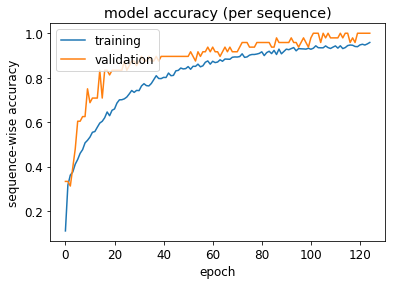

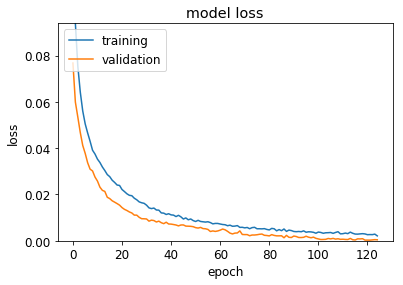

48/48 [==============================] - 0s 72us/step
Per-Sequence Test Accuracy: 1.0


In [108]:
# function for plotting metrics versus
# training epoch from a history object
def plot_histories(history_):
    
    # summarize history for accuracy
    plt.plot(history_.history['categorical_accuracy_per_sequence'])
    plt.plot(history_.history['val_categorical_accuracy_per_sequence'])
    plt.title('model accuracy (per sequence)')
    plt.ylabel('sequence-wise accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history_.history['loss'])
    plt.plot(history_.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim((0, history_.history['loss'][1]))
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    
    return None

# plot history and evaluate accuracy 
def plot_and_evaluate(model_, history_):

    plot_histories(history_)

    scores_ = model_.evaluate(
        x=X_test_uniq,               
        y=get_IOB2_onehot(y_test_IOB2_uniq), 
        batch_size=None, 
        verbose=1)
    
    print('Per-Sequence Test Accuracy:', scores_[2])
    
    return scores_

scores = plot_and_evaluate(model_IOB2_tagger, history_IOB2_tagger)

After roughly 120 iterations, we achieve roughly 100% accuracy on our test set, but only about 90% accuracy on our training set. This is pretty unusual and could be an artefact of our small dataset size. Our network might be memorizing keywords rather than learning about word relationships, and perhaps the distribution of these keywords is unbalanced and favours correct inference in the test set, whereas the more difficult cases are predominantly in the training set. 

We could mitigate this by shuffling the training and test datasets together and performing k-fold cross-validation. 

However, the focus of this tutorial is on building the pipeline, rather than optimizing our model performance (which can be done later), so we choose to proceed as-is. 

<a id='section_4_3'></a>
### 4.3 - Examining our IOB2 Tagger Predictions

Let's examine some sample predictions:

In [109]:
def are_tags_equal(tags_1, tags_2):
    # note: we cannot use np.equal for string comparison due
    # to a present python-numpy compatibility bug, so we will
    # need to convert the tags to integers first
    return np.min(np.equal(get_IOB2_ints(tags_1), 
                           get_IOB2_ints(tags_2)), axis=-1)
    

def view_IOB2_predictions(model_, X_data, y_data, 
                          num_samples=5, condition=None):
    
    # generate predictions
    preds = model_.predict(X_data)
    
    # map predictions to IOB2 tags
    pred_tags = get_IOB2_tags_from_ints(np.argmax(preds, axis=-1))
    
    # apply condition
    if condition is None:
        print('\nDisplaying Randoly-Selected Samples.')
        inds = np.arange(len(preds))
    elif condition is 'correct':
        print('\nDisplaying Samples with condition "Correct".')
        inds = np.arange(len(preds))[
            are_tags_equal(y_data, pred_tags)]
    elif condition is 'incorrect':
        print('\nDisplaying Samples with condition "Incorrect".')
        inds = np.arange(len(preds))[np.logical_not(
            are_tags_equal(y_data, pred_tags))]
    else:
        raise ValueError(
            'condition must be: "None", "correct" or "incorrect"')
            
    if num_samples > len(inds):
        num_samples = len(inds)
        print('*Only %s sample(s) of condition %s exist.' 
              % (num_samples, condition))

    print('[Format: word - predicted tag (true tag)]')
    # randomly draw examples from our predictions
    for i, index in enumerate(np.random.choice(inds, 
                                               size=num_samples, 
                                               replace=False)):
        
        this_X = X_data[index]
        this_y_pred = pred_tags[index]
        this_y_true = y_data[index]
        
        # sample number and correct/incorrect sequence status
        if are_tags_equal(this_y_pred, this_y_true) == True:
            outcome_str = 'correct prediction'
        else:
            outcome_str = 'incorrect prediction'
    
        print('\n-- Sample # %s (%s) --\n' % (i+1, outcome_str))
        
        # display sequence and predicted tags
        for j in range(len(this_X)):
            print(index_to_word[this_X[j]], 
                  '-', this_y_pred[j], 
                  '(%s)' % this_y_true[j])
            if this_X[j] == 0.0:
                break
        
    return None

view_IOB2_predictions(model_IOB2_tagger, X_test_uniq, y_test_IOB2_uniq, 
                      num_samples=3, condition='correct')


Displaying Samples with condition "Correct".
[Format: word - predicted tag (true tag)]

-- Sample # 1 (correct prediction) --

although - O (O)
the - O (O)
table - B (B)
may - O (O)
be - O (O)
closely - O (O)
situate - O (O)
the - O (O)
candle - B (B)
light - I (I)
food - B (B)
quality - O (O)
and - O (O)
service - B (B)
overcompensate - O (O)
<PAD> - O (O)

-- Sample # 2 (correct prediction) --

sometimes - O (O)
i - O (O)
get - O (O)
bad - O (O)
food - B (B)
and - O (O)
bad - O (O)
service - B (B)
sometimes - O (O)
i - O (O)
get - O (O)
good - O (O)
good - B (B)
and - O (O)
bad - O (O)
service - B (B)
<PAD> - O (O)

-- Sample # 3 (correct prediction) --

salads - B (B)
be - O (O)
a - O (O)
delicious - O (O)
way - O (O)
to - O (O)
begin - O (O)
the - O (O)
meal - O (O)
<PAD> - O (O)


<a id='section_4_4'></a>
### 4.4 - Inference on our own Review Sentences

Now let's feed in our own custom sentence and see what our tagger infers! First, some useful function defintions:

In [110]:
def raw_sentence_to_padded_sequence(sentence, sequence_size=62):
    
    print('\nOriginal Text:')
    print(sentence)
    
    print('\nPreprocessed Text:')
    sentence_proc = lemmatize(preprocessor(sentence))
    print(sentence_proc)

    print('\nCorresponding Integer Tokens:')
    sentence_ints = map_word_to_int(sentence_proc)
    print(sentence_ints)

    print('\nFinal Padded Sequence:')
    sentence_padded_seq = sequence.pad_sequences(
        [sentence_ints],                           
        maxlen=sequence_size,                         
        truncating='post',                           
        padding='post',                    
        value=word_to_index['<PAD>'])
    print(sentence_padded_seq[0])
    
    return sentence_padded_seq


def predict_and_display_IOB2_tags(model_, X_data_, shown_index=0):
    
    preds_ = model_.predict(X_data_)
    preds_tag_ = get_IOB2_tags_from_ints(np.argmax(preds_, axis=-1))
    
    # display sequence and predicted tags
    print('\nPredicted Tags:')
    for j in range(len(X_data_[shown_index])):
        print(index_to_word[X_data_[shown_index][j]], 
              '-', preds_tag_[shown_index][j])
        if X_data_[shown_index][j] == 0.0:
            
            break
            
    return None


Now let's feed it a custom review sentence and see what IOB2 tags it predicts:

In [111]:
my_rev_1 = "The french fries were soggy, and the sandwich was dry."
my_rev_padded_seq_1 = raw_sentence_to_padded_sequence(my_rev_1)
predict_and_display_IOB2_tags(model_IOB2_tagger, my_rev_padded_seq_1)           



Original Text:
The french fries were soggy, and the sandwich was dry.

Preprocessed Text:
['the', 'french', 'fry', 'be', 'soggy', 'and', 'the', 'sandwich', 'be', 'dry']

Corresponding Integer Tokens:
[2, 333, 261, 3, 483, 4, 2, 318, 3, 362]

Final Padded Sequence:
[  2 333 261   3 483   4   2 318   3 362   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]

Predicted Tags:
the - O
french - B
fry - I
be - O
soggy - O
and - O
the - O
sandwich - B
be - O
dry - O
<PAD> - O


Let's try another one:

In [112]:
my_rev_2 = "Service was slow, and the decor was gross, but the food was delicious."

my_rev_padded_seq_2 = raw_sentence_to_padded_sequence(my_rev_2)
predict_and_display_IOB2_tags(model_IOB2_tagger, my_rev_padded_seq_2)   


Original Text:
Service was slow, and the decor was gross, but the food was delicious.

Preprocessed Text:
['service', 'be', 'slow', 'and', 'the', 'decor', 'be', 'gross', 'but', 'the', 'food', 'be', 'delicious']

Corresponding Integer Tokens:
[19, 3, 509, 4, 2, 87, 3, 1335, 18, 2, 9, 3, 45]

Final Padded Sequence:
[  19    3  509    4    2   87    3 1335   18    2    9    3   45    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]

Predicted Tags:
service - B
be - O
slow - O
and - O
the - O
decor - B
be - O
gross - O
but - O
the - O
food - B
be - O
delicious - O
<PAD> - O


***
<a id='section_5'></a>
## 5) Aspect-Entity and Sentiment Extraction

Having labelled OTEs within our review sentences, we now seek to assign these an entity (category), aspect (attribute), and polarity. 

> **Goal**: Given a sentence sequence and an IOB2 tag *for a single OTE within that sentence*, identify (a) the entity:aspect (e.g. FOOD:QUALITY) and (b) the sentiment polarity (positive, negative, or neutral). 
* Inputs: Review sentence word sequences, distance-to-OTE tags (computed from IOB2 tags with OTEs separated); POS tags,
* Outputs: entity (category), aspect (attribute), and sentiment polarity.



<a id='section_5_1'></a>
### 5.1 - Data Prep

Before we proceed, we'll further preprocess our data to achieve the following:
* compute distance-to-OTE sequences from the IOB2 tags
* remove data samples for which there are no OTE terms
* window our data, so that our model focuses only on the subset of text within the vicinity of the OTE term

We acheive this with the following code:

In [113]:
# category-aspect-polarity preprocessor
def CAP_extraction_preprocessor(X_data,
                                X_POS_data,
                                X_len_data,
                                y_IOB2_tags,
                                sequence_length,
                                window_size,
                                y_CAT_data=None, 
                                y_ATTR_data=None,
                                y_POL_data=None):
    
    
    # check assumptions
    assert window_size < X_data.shape[1], (
        'Window size must be smaller than sequence length.')
    
    # find any rows that lack OTEs
    reject_indices = []
    count = 0 
    for i in range(y_IOB2_tags.shape[0]):
        B_index = np.where(y_IOB2_tags[i]=='B')[0]
        if len(B_index) == 0:
            reject_indices.append(i)
            
    # proceed only with rows containing at least one OTE
    if len(reject_indices) > 0 :
        print('Attention: omitted %s rows that were missing OTEs.' 
              % len(reject_indices))
        
        X_data = np.delete(X_data, reject_indices, axis=0)
        X_POS_data = np.delete(X_POS_data, reject_indices, axis=0)
        y_IOB2_tags = np.delete(y_IOB2_tags, reject_indices, axis=0)
        
        if y_CAT_data is not None:
            y_CAT_data = np.delete(y_CAT_data, reject_indices, axis=0)
        if y_ATTR_data is not None:
            y_ATTR_data = np.delete(y_ATTR_data, reject_indices, axis=0)
        if y_POL_data is not None:
            y_POL_data = np.delete(y_POL_data, reject_indices, axis=0)
    
    # initialize truncated arrays
    X_data_tr = np.zeros((X_data.shape[0], window_size), 
                        dtype=int)
    X_POS_data_tr = np.zeros((X_POS_data.shape[0], window_size), 
                            dtype=int)
    X_len_data_tr = np.zeros(X_len_data.shape[0], dtype=int)
    y_IOB2_tags_tr = np.empty((y_IOB2_tags.shape[0], window_size), 
                              dtype=str)
                             
    # compute distance vectors and truncate to window size
    X_OTE_dist = np.zeros(X_data.shape)
    X_OTE_dist_tr = np.zeros((X_data.shape[0], window_size))
    dist_ref_vec = np.arange(0, y_IOB2_tags.shape[1]) 
    window_ref_vec = np.arange(0, window_size)
    window_middle_index = math.floor(window_size/2)
    
    for i in range(y_IOB2_tags.shape[0]):
        
        # ** get distance vector **
        # (equals zero for B and I tags)
        B_index = np.where(y_IOB2_tags[i]=='B')[0]
        I_index = np.where(y_IOB2_tags[i]=='I')[0]
        
        if len(B_index) > 1:
            print('WARNING: multiple OTEs detected for')
            print('IOB2 tag vector located at index %s;' % i)
            print('proceeding with the first one.')

        # suffices for cases where we just have the B tag
        X_OTE_dist[i, :] = dist_ref_vec - B_index[0]
        
#         # if 'I' tags are present, offset dist so that
#         # positive distances are counted from the LAST 'I'
#         num_I = len(I_index)
#         if num_I > 0:
#             for elem in range(B_index[0] + 1, y_IOB2_tags.shape[1]):
#                 X_OTE_dist[i, elem] = X_OTE_dist[i, elem] - num_I
#             X_OTE_dist[i, I_index] = 0
            
    
        # ** truncate data sequences to specified window size **
        # (window is centered on B_index where possible)
        window_index_shift = B_index[0] - window_middle_index
        
        # case 1: window limited by sequence start
        if window_index_shift < 0:
            keep_indices = window_ref_vec
        # case 2: window limited by sequence end    
        elif (window_size + window_index_shift) > sequence_length:
            keep_indices = window_ref_vec + (sequence_length - window_size)
        # case 3: window fits within sequence
        else:
            keep_indices = window_ref_vec + window_index_shift
                             
        # ** populate this array row **
        X_data_tr[i] = X_data[i, keep_indices]
        X_OTE_dist_tr[i] = X_OTE_dist[i, keep_indices]
        X_POS_data_tr[i] = X_POS_data[i, keep_indices]
        y_IOB2_tags_tr[i] = y_IOB2_tags[i, keep_indices]
        
        # ** update X_len **
        # -- Since we've clipped the sequence, we must
        # -- update X_len to be equal to the new number
        # -- of non-padded entries
        first_padded_index = np.where(X_data_tr[i] == 0)[0]
        if len(first_padded_index) == 0:
            X_len_data_tr[i] = window_size
        else:
            X_len_data_tr[i] = first_padded_index[0]
    
    
    # generate dictionary for returned data
    return_data = {'X': X_data_tr.astype(int), 
                   'X_len': X_len_data_tr, 
                   'X_POS': X_POS_data_tr, 
                   'X_OTE_dist': X_OTE_dist_tr, 
                   'y_IOB2_tags': y_IOB2_tags_tr}
    if y_CAT_data is not None:
        return_data['y_CAT'] = y_CAT_data
    if y_ATTR_data is not None:
        return_data['y_ATTR'] = y_ATTR_data
    if y_POL_data is not None:
        return_data['y_POL'] = y_POL_data
    
    return return_data


print('**Preprocessing Training Set**')
CAP_train_data = CAP_extraction_preprocessor(                         
    X_data=X_train,                          
    X_POS_data=X_POS_train,                         
    X_len_data=X_len_train,                       
    y_IOB2_tags=y_train_IOB2,
    sequence_length=62,
    window_size=20,
    y_CAT_data=y_CAT_train,                       
    y_ATTR_data=y_ATTR_train,
    y_POL_data=y_POL_train)
    
    
print('\n**Preprocessing Test Set**')
CAP_test_data = CAP_extraction_preprocessor(                         
    X_data=X_test,                          
    X_POS_data=X_POS_test,                         
    X_len_data=X_len_test,                       
    y_IOB2_tags=y_test_IOB2,
    sequence_length=62,
    window_size=20,
    y_CAT_data=y_CAT_test,                       
    y_ATTR_data=y_ATTR_test,
    y_POL_data=y_POL_test)

**Preprocessing Training Set**
Attention: omitted 918 rows that were missing OTEs.

**Preprocessing Test Set**
Attention: omitted 18 rows that were missing OTEs.


Let's also create a helfpul function for displaying and checking the output of our data preprocessing (for verification and debug purposes):

In [114]:
def display_CAP_data_sequences(CAP_data_dict, row_num):
    print('\nDisplaying data sequences for row %s:' % row_num)
    print('-- CAT:', CAP_data_dict['y_CAT'][row_num])
    print('-- ATTR:', CAP_data_dict['y_ATTR'][row_num])
    print('-- POL:', CAP_data_dict['y_POL'][row_num])
    print('-- X_len:', CAP_data_dict['X_len'][row_num])
    
    pt = PrettyTable(['Seq. #', 
                      'Text', 
                      'IOB2 Tag', 
                      'Dist.', 
                      'POS Tag'])
    
    for i in range(CAP_data_dict['X'][row_num].shape[0]):
        pt.add_row([i, 
                    map_int_to_word(CAP_data_dict['X'][row_num])[i],
                    CAP_data_dict['y_IOB2_tags'][row_num][i], 
                    CAP_data_dict['X_OTE_dist'][row_num][i],
                    map_int_to_POS(CAP_data_dict['X_POS'][row_num])[i]])
    
    print(pt)
    
    return None



Now we can examine some examples of the preprocessed output to see that our windowing and distance vectors are being applied correctly. 

In [115]:
# display two examples (same sentence, different OTEs)
display_CAP_data_sequences(CAP_train_data, row_num=21)
display_CAP_data_sequences(CAP_train_data, row_num=22)


Displaying data sequences for row 21:
-- CAT: SERVICE
-- ATTR: GENERAL
-- POL: positive
-- X_len: 15
+--------+------------+----------+-------+---------+
| Seq. # |    Text    | IOB2 Tag | Dist. | POS Tag |
+--------+------------+----------+-------+---------+
|   0    | everything |    O     |  -7.0 |    NN   |
|   1    |     be     |    O     |  -6.0 |   VBZ   |
|   2    |   always   |    O     |  -5.0 |    RB   |
|   3    |    cook    |    O     |  -4.0 |   VBN   |
|   4    |     to     |    O     |  -3.0 |    TO   |
|   5    | perfection |    O     |  -2.0 |    NN   |
|   6    |    the     |    O     |  -1.0 |    DT   |
|   7    |  service   |    B     |  0.0  |    NN   |
|   8    |     be     |    O     |  1.0  |   VBZ   |
|   9    | excellent  |    O     |  2.0  |    JJ   |
|   10   |    the     |    O     |  3.0  |    DT   |
|   11   |   decor    |    O     |  4.0  |    NN   |
|   12   |    cool    |    O     |  5.0  |    NN   |
|   13   |    and     |    O     |  6.0  |    CC  

Lastly, we define some one-hot encoders:

In [116]:
# one-hot encoders
def get_CAT_onehot(y_CAT_data):
    y_CAT_int = np.vectorize(CAT_to_int.get)(y_CAT_data)
    return K.utils.to_categorical(y_CAT_int, len(CAT_to_int))

def get_ATTR_onehot(y_ATTR_data):
    y_ATTR_int = np.vectorize(ATTR_to_int.get)(y_ATTR_data)
    return K.utils.to_categorical(y_ATTR_int, len(ATTR_to_int))

def get_POL_onehot(y_POL_data):
    y_POL_int = np.vectorize(POL_to_int.get)(y_POL_data)
    return K.utils.to_categorical(y_POL_int, len(POL_to_int))

def get_POS_onehot(X_POS_ints):
    return K.utils.to_categorical(X_POS_ints, len(index_to_POS_tag))


<a id='section_5_2'></a>
### 5.2 - Model Definition

We'll choose to create a combined model that provides inference for all three **category**, **attribute**, and **polarity** classes concurrently. By no means is this necessarily the best approach, but we'll proceed for simplicity so that we can focus on building a complete inference pipeline. 

Here are the details:
> * We use a **stacked** architecture, inspired by <a href="https://arxiv.org/abs/1709.06309" target="_blank">in this paper</a>, comprised of 3 conv layers followed by an LSTM layer; the reasoning is that conv layers are particularly good at local feature extraction, whereas LSTMs allow us to capture relationships between these features over larger distances within a sentence. 
* We choose to embed our distance vectors, which has been found to provide improved results in similar inference problems (according to the papers found <a href="https://www.ijcai.org/Proceedings/15/Papers/192.pdf" target="_blank">here</a>,
<a href="http://www.aclweb.org/anthology/C14-1220" target="_blank">here</a>, and
<a href="https://arxiv.org/abs/1504.06580" target="_blank">here</a>.
* The inputs will be the CAP-preprocessed versions of `X` (tokenized text sequences), `X_POS` (Part-of-Speech tags), and `X_dist` (distance-to-OTE term), as well as the pretrained `embedding_matrix`.
* Outputs will be `y_CAT`, `y_ATTR`, and `y_POL`, which are the inferred **category** (entity), **attribute** (aspect), and **polarity** respectively. 

For a nice intro to LSTMs, <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/" target="_blank"> see this excellent post</a> by Christopher Olah.


In [117]:
def pretrained_embedding_initializer(
    shape=embedding_matrix.shape, 
    dtype=tf.float32,                                 
    partition_info=None):
    
    assert dtype is tf.float32
    return embedding_matrix


def build_CAP_extraction_network(
    window_size=20,                        
    num_conv_layers=3,                      
    num_conv_filter_channels=50,                      
    conv_kernel_size=3,                     
    conv_dropout_rate=0.3,
    num_LSTM_units=100, 
    num_dense_units=100):

    # define input sequence tensor shapes
    # -- text sequence
    seq_input = K.layers.Input(shape=(window_size, ), 
                               dtype='int32', 
                               name='seq_input')
    # -- POS tags (one-hot encoded)
    POS_input = K.layers.Input(shape=(window_size, len(index_to_POS_tag)), 
                               dtype='float32', 
                               name='POS_input')
    # -- distance vector
    dist_input = K.layers.Input(shape=(window_size, ), 
                                dtype='float32', 
                                name='dist_input')
    
    # create embedding layers for text and distance
    # -- for text sequence; will be masked on zero (pad)
    seq_embedded = Embedding(
        input_dim=embedding_matrix.shape[0],         
        output_dim=embedding_matrix.shape[1],
        mask_zero=False,  # not currently supported by conv1D
        embeddings_initializer=pretrained_embedding_initializer
        )(seq_input)
    
    # -- for distance vector
    dist_embedded = Embedding(
        input_dim=window_size, 
        output_dim=10, 
        embeddings_initializer='uniform'
        )(dist_input)
    
    # concatenate input features
    x = K.layers.Concatenate()([seq_embedded, 
                                dist_embedded, 
                                POS_input])
    
    # generate convolution layers
    for i in range(num_conv_layers):
        x = Conv1D(
            filters=num_conv_filter_channels, 
            kernel_size=conv_kernel_size, 
            strides=1, 
            padding='same', 
            data_format='channels_last', 
            activation='relu', 
            use_bias=True, 
            kernel_initializer='glorot_uniform', 
            bias_initializer='zeros')(x)
        
        x = Dropout(rate=conv_dropout_rate)(x)
 
    # apply LSTM layer
    # -- we want only the final hidden state,
    # -- therefore return_sequences=False
    x_LSTM_out = K.layers.LSTM(
        units=num_LSTM_units, 
        activation='tanh',       
        recurrent_activation='hard_sigmoid',         
        use_bias=True,           
        kernel_initializer='glorot_uniform',          
        recurrent_initializer='orthogonal',           
        bias_initializer='zeros',        
        dropout=0.0,          
        return_sequences=False, # refers to *hidden* states         
        return_state=False,  # refers to *cell* states    
        stateful=False)(x)
    
    # output branch associated with CAT prediction
    x_CAT = Dense(
        num_dense_units, 
        activation='relu')(x_LSTM_out)
    y_CAT_probas = Dense(
        len(CAT_to_int), 
        activation='softmax',
        name='CAT_output')(x_CAT)
    
    # output branch associated with ATTR prediction
    x_ATTR = Dense(
        num_dense_units, 
        activation='relu')(x_LSTM_out)
    y_ATTR_probas = Dense(
        len(ATTR_to_int), 
        activation='softmax', 
        name='ATTR_output')(x_ATTR)
    
    # output branch associated with POL prediction
    x_POL = Dense(
        num_dense_units, 
        activation='relu')(x_LSTM_out)
    y_POL_probas = Dense(
        len(POL_to_int), 
        activation='softmax', 
        name='POL_output')(x_POL)
    
    # assemble
    model = K.Model(
        inputs=[seq_input, POS_input, dist_input],             
        outputs=[y_CAT_probas, y_ATTR_probas, y_POL_probas])
    
    return model
    
model_CAP_extraction = build_CAP_extraction_network()
model_CAP_extraction.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          (None, 20)           0                                            
__________________________________________________________________________________________________
dist_input (InputLayer)         (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 100)      282500      seq_input[0][0]                  
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 10)       200         dist_input[0][0]                 
__________________________________________________________________________________________________
POS_input 

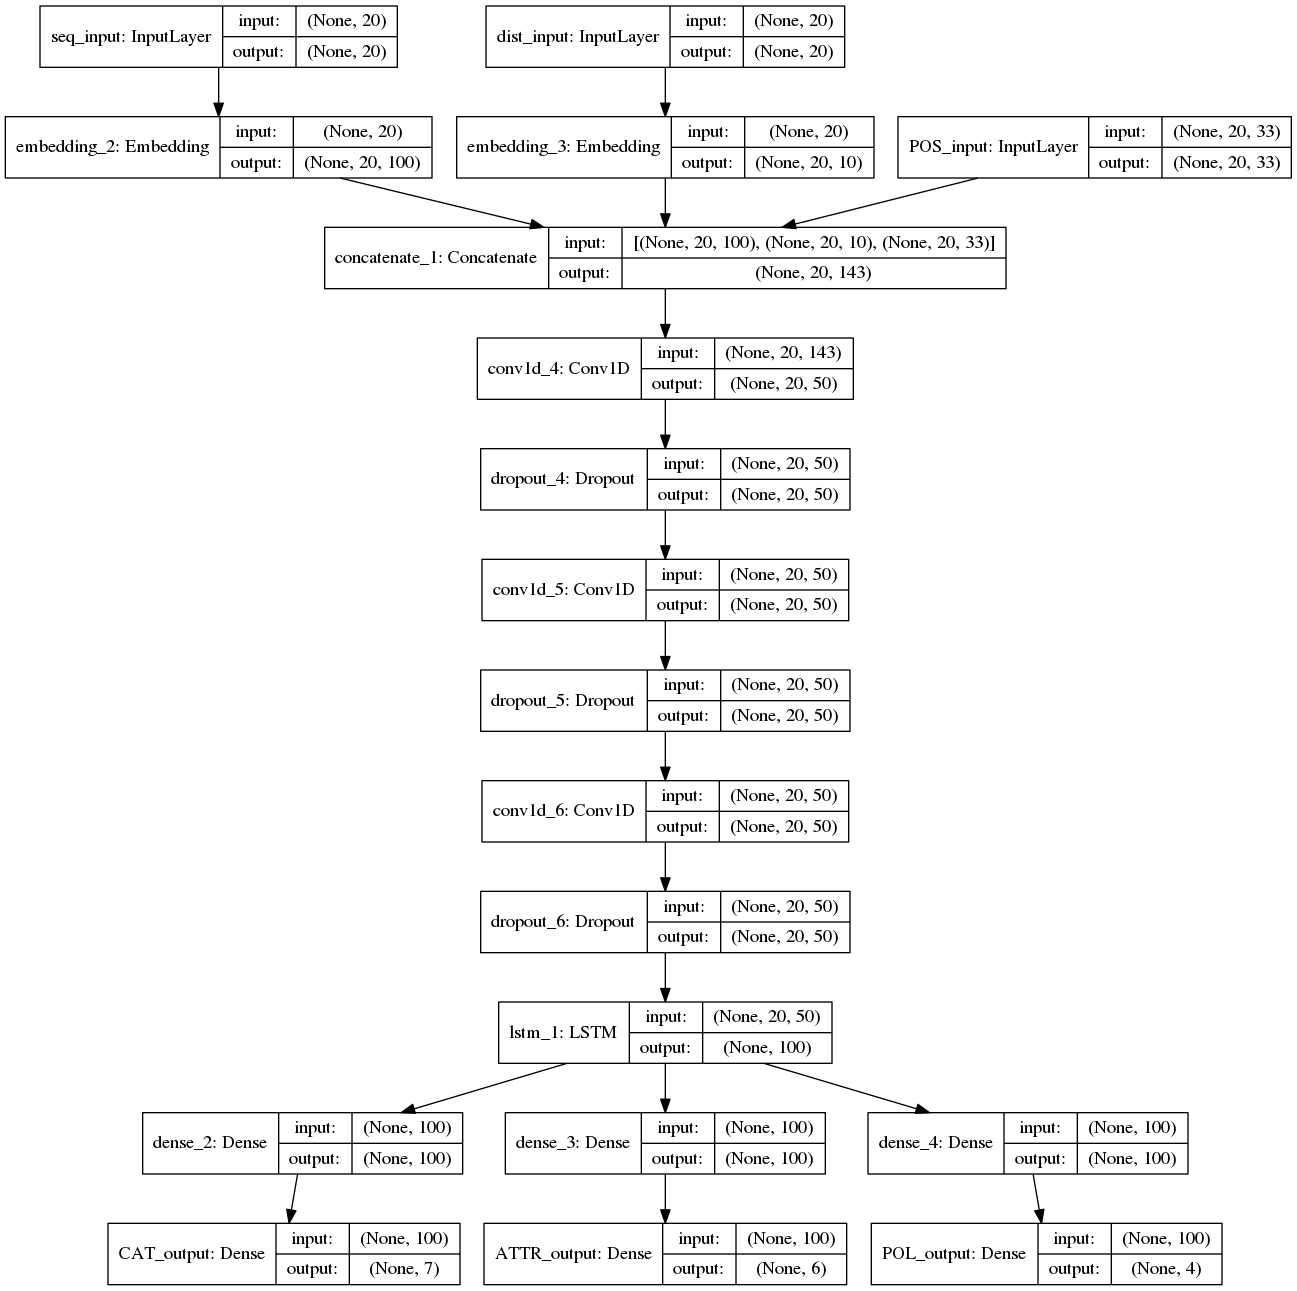

In [118]:
# visualizing our model
plot_model(model_CAP_extraction, to_file='model_CAP_extraction_plot.png', 
           show_shapes=True, show_layer_names=True)
Image('model_CAP_extraction_plot.png')

Note that when training RNNs, such as the LSTM layer, we typically mask our sequences so that padded entries are ignored. However, due to our network being stacked on top of CNNs, there is currently no straightforward way to do this in Keras (v2.2.2) since conv layers have not yet been made compatible with mask objects. 

<a id='section_5_3'></a>
### 5.3 - Model Training and Evaluation

We train in the usual way, but this time we specifying our multiple intputs and outputs by referring to the specific layer names using a dictionary. 

In [119]:
np.random.seed(RANDOM_SEED)  # for reproducibility
tf.set_random_seed(RANDOM_SEED)

model_CAP_extraction.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop',  # what the paper uses
    metrics=['accuracy'])

history_CAP_exctraction = model_CAP_extraction.fit(
    x={'seq_input': CAP_train_data['X'],
       'POS_input': get_POS_onehot(CAP_train_data['X_POS']),
       'dist_input': CAP_train_data['X_OTE_dist']}, 
    y={'CAT_output': get_CAT_onehot(CAP_train_data['y_CAT']),
       'ATTR_output': get_ATTR_onehot(CAP_train_data['y_ATTR']),
       'POL_output': get_POL_onehot(CAP_train_data['y_POL'])},
    batch_size=128, 
    epochs=125, 
    verbose=1, 
    callbacks=None, 
    validation_data=(
        {'seq_input': CAP_test_data['X'],      
         'POS_input': get_POS_onehot(CAP_test_data['X_POS']),       
         'dist_input': CAP_test_data['X_OTE_dist']},       
        {'CAT_output': get_CAT_onehot(CAP_test_data['y_CAT']),        
         'ATTR_output': get_ATTR_onehot(CAP_test_data['y_ATTR']),          
         'POL_output': get_POL_onehot(CAP_test_data['y_POL'])}), 
    shuffle=True, 
    initial_epoch=0)


Train on 1880 samples, validate on 55 samples
Epoch 1/125
1880/1880 [==============================] - 1s 539us/step - loss: 3.5987 - CAT_output_loss: 1.5030 - ATTR_output_loss: 1.3127 - POL_output_loss: 0.7829 - CAT_output_acc: 0.4734 - ATTR_output_acc: 0.3936 - POL_output_acc: 0.7016 - val_loss: 3.2733 - val_CAT_output_loss: 1.4112 - val_ATTR_output_loss: 1.0222 - val_POL_output_loss: 0.8400 - val_CAT_output_acc: 0.5273 - val_ATTR_output_acc: 0.5091 - val_POL_output_acc: 0.6364
Epoch 2/125
1880/1880 [==============================] - 0s 177us/step - loss: 3.3491 - CAT_output_loss: 1.3986 - ATTR_output_loss: 1.2200 - POL_output_loss: 0.7306 - CAT_output_acc: 0.5064 - ATTR_output_acc: 0.4096 - POL_output_acc: 0.7011 - val_loss: 3.2256 - val_CAT_output_loss: 1.3673 - val_ATTR_output_loss: 1.0192 - val_POL_output_loss: 0.8391 - val_CAT_output_acc: 0.5273 - val_ATTR_output_acc: 0.4182 - val_POL_output_acc: 0.6364
Epoch 3/125
1880/1880 [==============================] - 0s 174us/step - los

Epoch 20/125
1880/1880 [==============================] - 0s 173us/step - loss: 1.9704 - CAT_output_loss: 0.6560 - ATTR_output_loss: 0.6458 - POL_output_loss: 0.6685 - CAT_output_acc: 0.7516 - ATTR_output_acc: 0.7867 - POL_output_acc: 0.7191 - val_loss: 1.7518 - val_CAT_output_loss: 0.5317 - val_ATTR_output_loss: 0.4737 - val_POL_output_loss: 0.7464 - val_CAT_output_acc: 0.8000 - val_ATTR_output_acc: 0.8909 - val_POL_output_acc: 0.6727
Epoch 21/125
1880/1880 [==============================] - 0s 168us/step - loss: 1.9189 - CAT_output_loss: 0.6122 - ATTR_output_loss: 0.6384 - POL_output_loss: 0.6682 - CAT_output_acc: 0.7846 - ATTR_output_acc: 0.7957 - POL_output_acc: 0.7160 - val_loss: 1.8806 - val_CAT_output_loss: 0.5519 - val_ATTR_output_loss: 0.5882 - val_POL_output_loss: 0.7405 - val_CAT_output_acc: 0.8000 - val_ATTR_output_acc: 0.8364 - val_POL_output_acc: 0.6727
Epoch 22/125
1880/1880 [==============================] - 0s 176us/step - loss: 1.8288 - CAT_output_loss: 0.5555 - ATTR_

Epoch 39/125
1880/1880 [==============================] - 0s 173us/step - loss: 1.1386 - CAT_output_loss: 0.2492 - ATTR_output_loss: 0.4878 - POL_output_loss: 0.4017 - CAT_output_acc: 0.9128 - ATTR_output_acc: 0.8293 - POL_output_acc: 0.8495 - val_loss: 1.0202 - val_CAT_output_loss: 0.1969 - val_ATTR_output_loss: 0.3665 - val_POL_output_loss: 0.4567 - val_CAT_output_acc: 0.9091 - val_ATTR_output_acc: 0.9273 - val_POL_output_acc: 0.8364
Epoch 40/125
1880/1880 [==============================] - 0s 172us/step - loss: 1.1163 - CAT_output_loss: 0.2478 - ATTR_output_loss: 0.4785 - POL_output_loss: 0.3900 - CAT_output_acc: 0.9101 - ATTR_output_acc: 0.8319 - POL_output_acc: 0.8580 - val_loss: 1.3652 - val_CAT_output_loss: 0.3681 - val_ATTR_output_loss: 0.5616 - val_POL_output_loss: 0.4355 - val_CAT_output_acc: 0.8909 - val_ATTR_output_acc: 0.9091 - val_POL_output_acc: 0.8182
Epoch 41/125
1880/1880 [==============================] - 0s 179us/step - loss: 1.1556 - CAT_output_loss: 0.2409 - ATTR_

Epoch 58/125
1880/1880 [==============================] - 0s 170us/step - loss: 0.8003 - CAT_output_loss: 0.1512 - ATTR_output_loss: 0.3955 - POL_output_loss: 0.2536 - CAT_output_acc: 0.9516 - ATTR_output_acc: 0.8495 - POL_output_acc: 0.8989 - val_loss: 0.6520 - val_CAT_output_loss: 0.1147 - val_ATTR_output_loss: 0.2845 - val_POL_output_loss: 0.2528 - val_CAT_output_acc: 0.9455 - val_ATTR_output_acc: 0.9455 - val_POL_output_acc: 0.9091
Epoch 59/125
1880/1880 [==============================] - 0s 173us/step - loss: 0.7868 - CAT_output_loss: 0.1595 - ATTR_output_loss: 0.3961 - POL_output_loss: 0.2313 - CAT_output_acc: 0.9505 - ATTR_output_acc: 0.8500 - POL_output_acc: 0.9122 - val_loss: 0.7469 - val_CAT_output_loss: 0.0955 - val_ATTR_output_loss: 0.2564 - val_POL_output_loss: 0.3950 - val_CAT_output_acc: 0.9455 - val_ATTR_output_acc: 0.9455 - val_POL_output_acc: 0.8727
Epoch 60/125
1880/1880 [==============================] - 0s 176us/step - loss: 0.7940 - CAT_output_loss: 0.1542 - ATTR_

Epoch 77/125
1880/1880 [==============================] - 0s 180us/step - loss: 0.6520 - CAT_output_loss: 0.1240 - ATTR_output_loss: 0.3293 - POL_output_loss: 0.1987 - CAT_output_acc: 0.9537 - ATTR_output_acc: 0.8660 - POL_output_acc: 0.9271 - val_loss: 0.4975 - val_CAT_output_loss: 0.1195 - val_ATTR_output_loss: 0.1668 - val_POL_output_loss: 0.2112 - val_CAT_output_acc: 0.9818 - val_ATTR_output_acc: 0.9455 - val_POL_output_acc: 0.9091
Epoch 78/125
1880/1880 [==============================] - 0s 182us/step - loss: 0.5646 - CAT_output_loss: 0.1078 - ATTR_output_loss: 0.2963 - POL_output_loss: 0.1605 - CAT_output_acc: 0.9596 - ATTR_output_acc: 0.8888 - POL_output_acc: 0.9426 - val_loss: 0.4136 - val_CAT_output_loss: 0.0721 - val_ATTR_output_loss: 0.1643 - val_POL_output_loss: 0.1772 - val_CAT_output_acc: 0.9818 - val_ATTR_output_acc: 0.9455 - val_POL_output_acc: 0.9273
Epoch 79/125
1880/1880 [==============================] - 0s 174us/step - loss: 0.5969 - CAT_output_loss: 0.1184 - ATTR_

Epoch 96/125
1880/1880 [==============================] - 0s 182us/step - loss: 0.4572 - CAT_output_loss: 0.0799 - ATTR_output_loss: 0.2567 - POL_output_loss: 0.1206 - CAT_output_acc: 0.9681 - ATTR_output_acc: 0.8952 - POL_output_acc: 0.9527 - val_loss: 0.2920 - val_CAT_output_loss: 0.0447 - val_ATTR_output_loss: 0.1217 - val_POL_output_loss: 0.1256 - val_CAT_output_acc: 0.9818 - val_ATTR_output_acc: 0.9636 - val_POL_output_acc: 0.9636
Epoch 97/125
1880/1880 [==============================] - 0s 183us/step - loss: 0.4343 - CAT_output_loss: 0.0770 - ATTR_output_loss: 0.2409 - POL_output_loss: 0.1163 - CAT_output_acc: 0.9702 - ATTR_output_acc: 0.8968 - POL_output_acc: 0.9559 - val_loss: 0.3007 - val_CAT_output_loss: 0.0535 - val_ATTR_output_loss: 0.1199 - val_POL_output_loss: 0.1273 - val_CAT_output_acc: 0.9636 - val_ATTR_output_acc: 0.9636 - val_POL_output_acc: 0.9455
Epoch 98/125
1880/1880 [==============================] - 0s 184us/step - loss: 0.4390 - CAT_output_loss: 0.0726 - ATTR_

Epoch 115/125
1880/1880 [==============================] - 0s 182us/step - loss: 0.3724 - CAT_output_loss: 0.0761 - ATTR_output_loss: 0.1996 - POL_output_loss: 0.0968 - CAT_output_acc: 0.9729 - ATTR_output_acc: 0.9080 - POL_output_acc: 0.9638 - val_loss: 0.1629 - val_CAT_output_loss: 0.0364 - val_ATTR_output_loss: 0.0738 - val_POL_output_loss: 0.0527 - val_CAT_output_acc: 0.9818 - val_ATTR_output_acc: 0.9636 - val_POL_output_acc: 0.9818
Epoch 116/125
1880/1880 [==============================] - 0s 181us/step - loss: 0.3627 - CAT_output_loss: 0.0629 - ATTR_output_loss: 0.2053 - POL_output_loss: 0.0945 - CAT_output_acc: 0.9771 - ATTR_output_acc: 0.9074 - POL_output_acc: 0.9628 - val_loss: 0.2487 - val_CAT_output_loss: 0.0386 - val_ATTR_output_loss: 0.1059 - val_POL_output_loss: 0.1042 - val_CAT_output_acc: 0.9818 - val_ATTR_output_acc: 0.9636 - val_POL_output_acc: 0.9636
Epoch 117/125
1880/1880 [==============================] - 0s 180us/step - loss: 0.3652 - CAT_output_loss: 0.0650 - AT

As before, we'll create some functions for visualing the results:

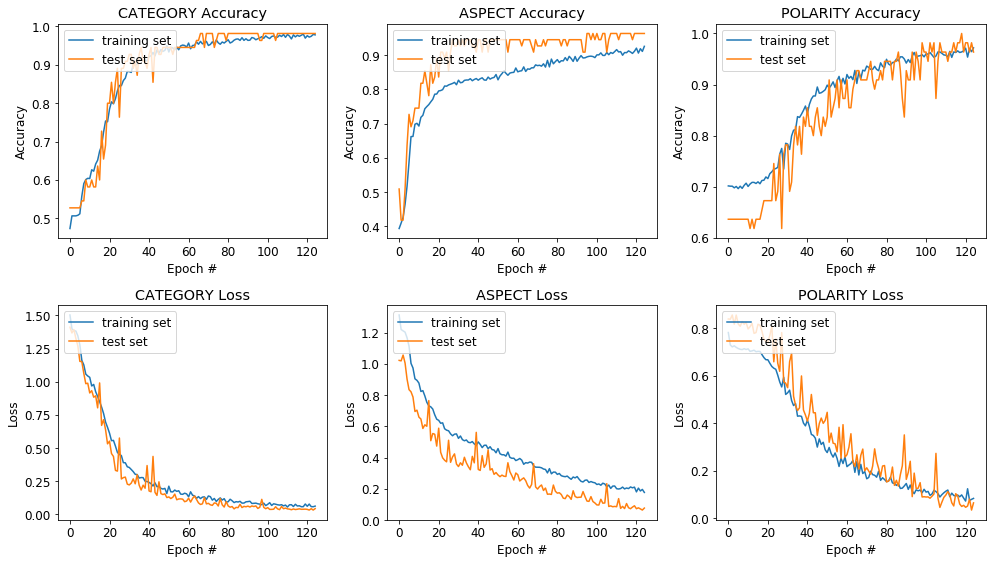

55/55 [==============================] - 0s 324us/step

CATEGORY Accuracy: 0.9818
ASPECT Accuracy: 0.9636
POLARITY Accuracy: 0.9636


In [120]:
def plot_CAP_extraction_histories(history_):
    
    fig, ax = plt.subplots(nrows=2, ncols=3,      
                           sharex=False, sharey=False,    
                           figsize=(14, 8))
    
    ax[0,0].plot(history_.history['CAT_output_acc'])
    ax[0,0].plot(history_.history['val_CAT_output_acc'])
    ax[0,0].set_title('CATEGORY Accuracy')
    ax[0,0].set_ylabel('Accuracy')
    ax[0,0].set_xlabel('Epoch #')
    ax[0,0].legend(['training set', 'test set'], loc='upper left')

    ax[0,1].plot(history_.history['ATTR_output_acc'])
    ax[0,1].plot(history_.history['val_ATTR_output_acc'])
    ax[0,1].set_title('ASPECT Accuracy')
    ax[0,1].set_ylabel('Accuracy')
    ax[0,1].set_xlabel('Epoch #')
    ax[0,1].legend(['training set', 'test set'], loc='upper left')
    
    ax[0,2].plot(history_.history['POL_output_acc'])
    ax[0,2].plot(history_.history['val_POL_output_acc'])
    ax[0,2].set_title('POLARITY Accuracy')
    ax[0,2].set_ylabel('Accuracy')
    ax[0,2].set_xlabel('Epoch #')
    ax[0,2].legend(['training set', 'test set'], loc='upper left')
    
    ax[1,0].plot(history_.history['CAT_output_loss'])
    ax[1,0].plot(history_.history['val_CAT_output_loss'])
    ax[1,0].set_title('CATEGORY Loss')
    ax[1,0].set_ylabel('Loss')
    ax[1,0].set_xlabel('Epoch #')
    ax[1,0].legend(['training set', 'test set'], loc='upper left')

    ax[1,1].plot(history_.history['ATTR_output_loss'])
    ax[1,1].plot(history_.history['val_ATTR_output_loss'])
    ax[1,1].set_title('ASPECT Loss')
    ax[1,1].set_ylabel('Loss')
    ax[1,1].set_xlabel('Epoch #')
    ax[1,1].legend(['training set', 'test set'], loc='upper left')
    
    ax[1,2].plot(history_.history['POL_output_loss'])
    ax[1,2].plot(history_.history['val_POL_output_loss'])
    ax[1,2].set_title('POLARITY Loss')
    ax[1,2].set_ylabel('Loss')
    ax[1,2].set_xlabel('Epoch #')
    ax[1,2].legend(['training set', 'test set'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return None

def evaluate_CAP_performance(model_):

    scores_ = model_.evaluate(
        x={'seq_input': CAP_test_data['X'],
           'POS_input': get_POS_onehot(CAP_test_data['X_POS']),
           'dist_input': CAP_test_data['X_OTE_dist']}, 
        y={'CAT_output': get_CAT_onehot(CAP_test_data['y_CAT']),
           'ATTR_output': get_ATTR_onehot(CAP_test_data['y_ATTR']),
           'POL_output': get_POL_onehot(CAP_test_data['y_POL'])},
        batch_size=None, 
        verbose=1)
    
    print('\nCATEGORY Accuracy: %.4f' % scores_[4])
    print('ASPECT Accuracy: %.4f' % scores_[5])
    print('POLARITY Accuracy: %.4f' % scores_[6])

    return scores_


plot_CAP_extraction_histories(history_CAP_exctraction)
scores_CAP = evaluate_CAP_performance(model_CAP_extraction)

We obtain fairly high test accuries; meanwhile our training accuracies for category and attribute are 5-10% lower. Once again, this may be due to the small dataset size and how the vocabulary is distributed between train and test sets as hypothesized earlier. So we don't yet know whether this is because our network understands word feature relations, or if it has merely memorized keywords. In a more realistic setting, we would train our network on a larger corpus and perhaps include some pretrained layers via transfer learning. But what we're interested in for this tutorial is building the pipeline, so we'll proceed without further experimentation. 

***
<a id='section_6'></a>
## 6) Complete Inference Pipeline using Combined Model

Finally, we'll create a function that takes a review sentence as an input, and runs the complete pipeline to:
* preprocess the data, 
* predict IOB2 tags to identify OTE target words using the first model
* infer the entity, attribute, and polarity using the second model, based on the OTE target words identified by the first

When creating this pipeline, we'll also need take tagged sequences with multiple OTEs (from the output of model 1) and separate these so that we feed only one OTE at a time to model 2. We achieve this using the functions below:

In [121]:
def predict_CAP(model_, CAP_data):
    
    pred_ = model_.predict(
        x={'seq_input': CAP_data['X'],
           'POS_input': get_POS_onehot(CAP_data['X_POS']),
           'dist_input': CAP_data['X_OTE_dist']}, 
            batch_size=1) 
    
    CAP_pred_ = int_to_CAT[np.argmax(pred_[0], axis=-1)[0]]
    ATTR_pred_ = int_to_ATTR[np.argmax(pred_[1], axis=-1)[0]]
    POL_pred_ = int_to_POL[np.argmax(pred_[2], axis=-1)[0]]
    
    
    CAP_preds_ = {'CAT': CAP_pred_, 
                  'ATTR': ATTR_pred_,
                  'POL': POL_pred_}
    
    return CAP_preds_


def display_sequence_results(CAP_data_dict):
    
    row_num = 0
    
    print('SEQUENCES:')

    pt = PrettyTable(['Seq. #', 
                      'Text', 
                      'IOB2 Tag', 
                      'Dist.', 
                      'POS Tag'])
    
    for i in range(CAP_data_dict['X'][row_num].shape[0]):
        pt.add_row([i, 
                    map_int_to_word(CAP_data_dict['X'][row_num])[i],
                    CAP_data_dict['y_IOB2_tags'][row_num][i], 
                    CAP_data_dict['X_OTE_dist'][row_num][i],
                    map_int_to_POS(CAP_data_dict['X_POS'][row_num])[i]])
    
    print(pt)

    return None


def inference_pipeline(raw_text, show_sequences=False):
    """
    Notes: 
    
        * must use the same sequence and window sizes that were
          used for model training. 
    
        * accepts only a single sentence at a time (not batches).
    """
    SEQUENCE_LENGTH = 62
    WINDOW_SIZE = 20
    
    print('\n*** Input sentence: ***')
    print(raw_text)
    
    # apply preprocessor to clean text
    text_cln = preprocessor(raw_text)
    
    # obtain Part-of-Speech tags
    text_POS_tags = np.array(get_POS_tags(text_cln))
    
    # lemmatize cleaned text
    text_cln_lm = lemmatize(text_cln)
    
    # convert words to integer tokens
    text_cln_lm_ints = map_word_to_int(text_cln_lm)
    
    # pad text sequences
    text_int_pad_seq = sequence.pad_sequences(
        [text_cln_lm_ints],                           
        maxlen=sequence_size,                         
        truncating='post',                           
        padding='post',                    
        value=word_to_index['<PAD>'])
    text_orig_len = []
    text_orig_len.append(len(text_int_pad_seq))
    text_orig_len = np.array(text_orig_len)
    
    # pad POS tag sequences
    text_POS_int_pad_seq = sequence.pad_sequences(
        [map_POS_to_int(text_POS_tags)],                    
        maxlen=sequence_size,                
        truncating='post',                   
        padding='post', 
        value=POS_tag_to_index['<PAD>']).astype(np.int32)
    
    # predict IOB2 tags
    IOB2_int_pred = model_IOB2_tagger.predict(text_int_pad_seq)
    IOB2_tag_pred = get_IOB2_tags_from_ints(
        np.argmax(IOB2_int_pred, axis=-1))
    
    
    # find OTE indices
    B_indices = np.where(IOB2_tag_pred[0]=='B')[0]
    
    # create separate IOB2 tags if there are multiple OTEs
    if len(B_indices) > 1:
        
        IOB2_temp = np.full(
            (len(B_indices), SEQUENCE_LENGTH), 'O', dtype=str)
        
        for OTE_id in range(len(B_indices)):
            
            # set "B" tag for this OTE
            this_B = B_indices[OTE_id]
            IOB2_temp[OTE_id, this_B] = 'B'
            
            # check if any "I" tags follow the "B"
            for next_index in range(1, 10):
                if IOB2_tag_pred[0, this_B + next_index] == 'I':
                    IOB2_temp[OTE_id, this_B + next_index] = 'I'
                else:
                    break
        
        # reassign IOB2 tag variable
        IOB2_tag_pred = IOB2_temp
            
    
    results = []
    print('\nDetected %s OTE(s)' % len(B_indices))
    for i in range(IOB2_tag_pred.shape[0]):

        # apply CAP extraction preprocessor
        CAP_data = CAP_extraction_preprocessor(                         
            X_data=text_int_pad_seq,                          
            X_POS_data=text_POS_int_pad_seq,                         
            X_len_data=text_orig_len,                       
            y_IOB2_tags=IOB2_tag_pred[i].reshape(1, SEQUENCE_LENGTH),
            sequence_length=SEQUENCE_LENGTH,
            window_size=WINDOW_SIZE)
        
        # perform CAP extraction
        CAP_pred = predict_CAP(model_CAP_extraction, CAP_data)
        
        # also isolate the OTE
        OTE_B_indices = np.where(IOB2_tag_pred[i]=='B')[0]
        OTE_I_indices = np.where(IOB2_tag_pred[i]=='I')[0]
        OTE_indices = np.concatenate((OTE_B_indices, OTE_I_indices))
        
        this_OTE = map_int_to_word(text_int_pad_seq[0, OTE_indices])
        
        # print results 
        print('\n========================')
        print('Results for OTE # %s' % (i+1))
        print('========================')

        print('INFERRED:')
        print('* OTE (Target Words):', this_OTE)
        print('* Category (Entity):', CAP_pred['CAT'])
        print('* Aspect (Attribute):', CAP_pred['ATTR'])
        print('* Polarity:', CAP_pred['POL'])
        
        if show_sequences is True:
            display_sequence_results(CAP_data)
            
        # collect for export
        these_results = {'OTE': this_OTE, 
                         'CAT': CAP_pred['CAT'], 
                         'ATTR': CAP_pred['ATTR'],
                         'POL': CAP_pred['POL']}
        
        results.append(these_results)

    return results
    

Now let's test this out on a few custom review sentences. First a simple one:

In [122]:
my_rev_1 = "The french fries were soggy, and the sandwich was dry."
results = inference_pipeline(my_rev_1, show_sequences=True)


*** Input sentence: ***
The french fries were soggy, and the sandwich was dry.

Detected 2 OTE(s)

Results for OTE # 1
INFERRED:
* OTE (Target Words): ['french', 'fry']
* Category (Entity): FOOD
* Aspect (Attribute): QUALITY
* Polarity: negative
SEQUENCES:
+--------+----------+----------+-------+---------+
| Seq. # |   Text   | IOB2 Tag | Dist. | POS Tag |
+--------+----------+----------+-------+---------+
|   0    |   the    |    O     |  -1.0 |    DT   |
|   1    |  french  |    B     |  0.0  |    JJ   |
|   2    |   fry    |    I     |  1.0  |   NNS   |
|   3    |    be    |    O     |  2.0  |   VBD   |
|   4    |  soggy   |    O     |  3.0  |    JJ   |
|   5    |   and    |    O     |  4.0  |    CC   |
|   6    |   the    |    O     |  5.0  |    DT   |
|   7    | sandwich |    O     |  6.0  |    NN   |
|   8    |    be    |    O     |  7.0  |   VBD   |
|   9    |   dry    |    O     |  8.0  |    JJ   |
|   10   |  <PAD>   |    O     |  9.0  |  <PAD>  |
|   11   |  <PAD>   |    O  

Now a more complicated one:

In [123]:
my_rev_2 = "Service was terribly slow and the restaurant \
was noisy, but the waiter was friendly and the calamari was very delicious."
CAP_data_temp = inference_pipeline(my_rev_2)


*** Input sentence: ***
Service was terribly slow and the restaurant was noisy, but waiter was friendly and the calamari was very delicious.

Detected 4 OTE(s)

Results for OTE # 1
INFERRED:
* OTE (Target Words): ['service']
* Category (Entity): SERVICE
* Aspect (Attribute): GENERAL
* Polarity: negative

Results for OTE # 2
INFERRED:
* OTE (Target Words): ['restaurant']
* Category (Entity): AMBIENCE
* Aspect (Attribute): GENERAL
* Polarity: negative

Results for OTE # 3
INFERRED:
* OTE (Target Words): ['waiter']
* Category (Entity): SERVICE
* Aspect (Attribute): GENERAL
* Polarity: positive

Results for OTE # 4
INFERRED:
* OTE (Target Words): ['calamari']
* Category (Entity): FOOD
* Aspect (Attribute): QUALITY
* Polarity: positive


However, our model isn't perfect. Here's a case where it makes some incorrect inferences, perhaps an indication that it has relied to heavily on keywords and hasn't made good use of the distance feature vector. 

In [124]:
my_rev_3 = "The coffee was excellent, but the desert was too expensive."
CAP_data_temp = inference_pipeline(my_rev_3)


*** Input sentence: ***
The coffee was excellent, but the desert was too expensive.

Detected 2 OTE(s)

Results for OTE # 1
INFERRED:
* OTE (Target Words): ['coffee']
* Category (Entity): DRINKS
* Aspect (Attribute): PRICES
* Polarity: positive

Results for OTE # 2
INFERRED:
* OTE (Target Words): ['desert']
* Category (Entity): FOOD
* Aspect (Attribute): PRICES
* Polarity: positive


***
<a id='section_7'></a>
## 7) Final Remarks

In summary, this tutorial demonstrated how to build an inference pipeline for finding opinion-term expressions (OTEs) and classifying these based on entity, aspect, and sentiment polarity. By now, you should be familiar with how to:
> * clean and preprocess text data
* make use of pre-trained embedding vectors
* generate Part-of-Speech (POS) tags
* perform sequence-to-sequence inference for IOB2 tag generation
* define custom (per-sequence) accuracy metrics

Having developed these tools and built a basic pipeline, we are ready to go back and optimize our models. Better yet, we can train our models on a larger dataset such as the <a href="https://old.datahub.io/dataset/usage-review-corpus" target="_blank">USAGE review corpus</a>, which also labels opinion terms that can be used for relational extraction, allowing us to implement more powerful architectures such as the one described <a href="https://arxiv.org/abs/1709.06309" target="_blank">here</a>.  

***